## Llama 70b

### Word Count 100

Data successfully saved to llama70b_cat3_r100_gen_data.csv


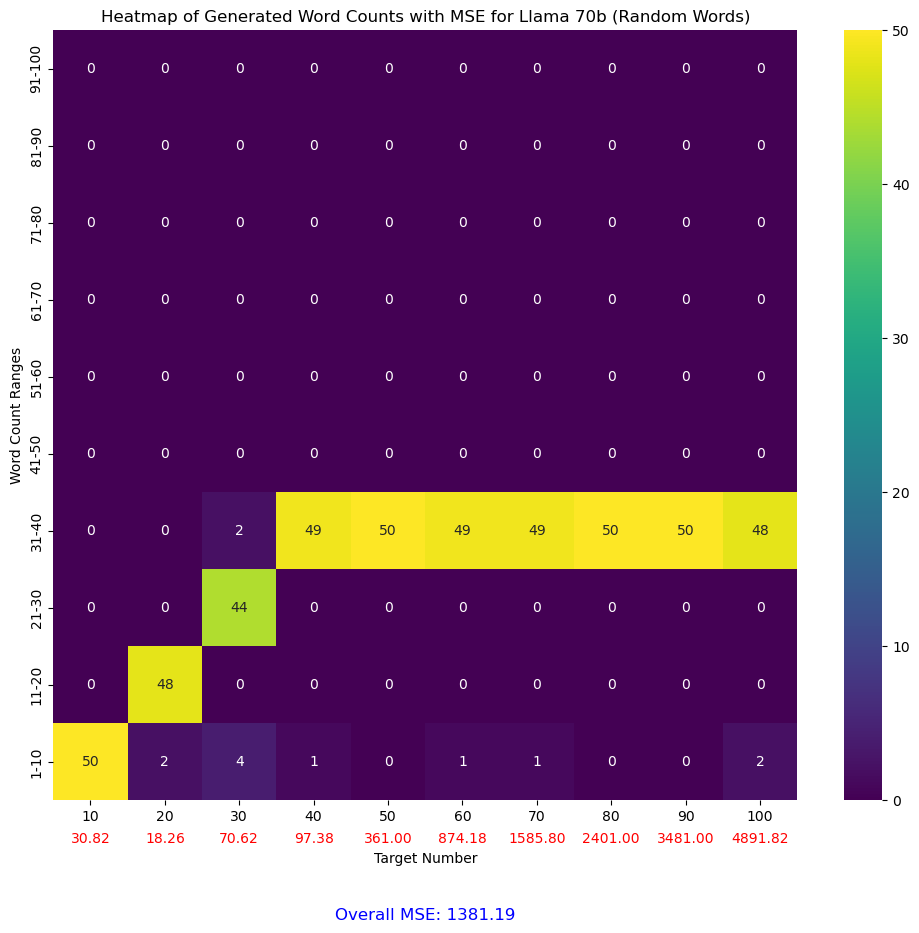

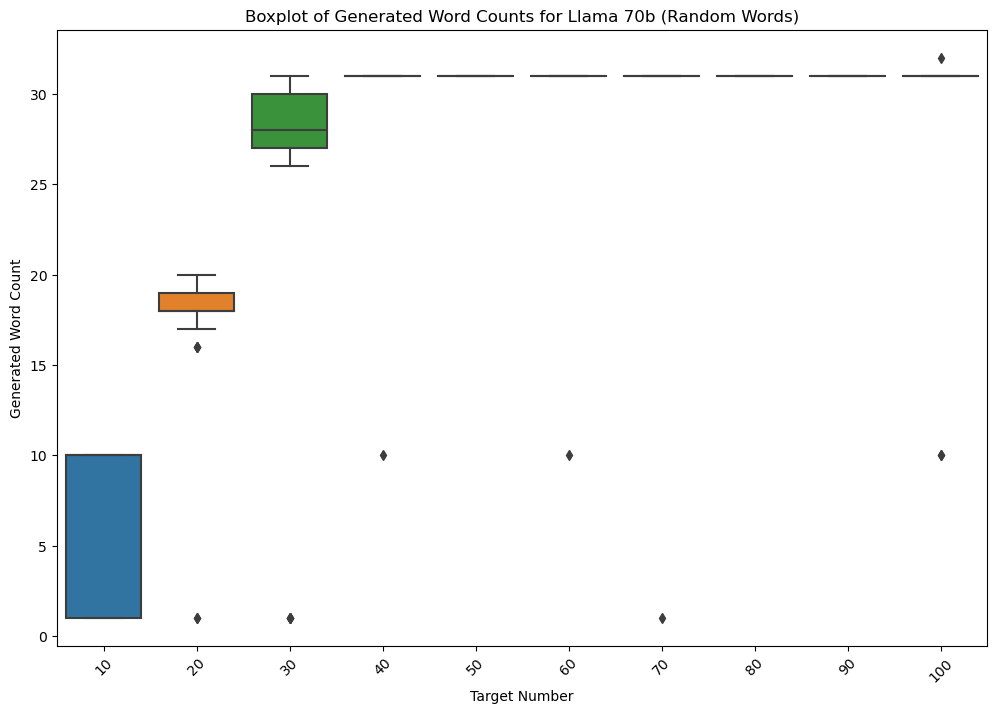

In [42]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

directory = r"C:\Users\Kaan\Desktop\thesis\llama3_70b\generate\llama3_70b_cat3_range100"

def process_files(directory):
    gen_data = defaultdict(list)
        # List to temporarily store data for CSV creation
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    generated_text = lines[3]  # This should contain the generated text
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                    
                    # Count the number of words in the generated text
                    word_count = len(generated_text.split())
                    
                    # Store the word counts for each target number
                    gen_data[target_number].append(word_count)
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = word_count
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama70b_cat3_r100_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")
    return gen_data

def calculate_mse(data):
    mses = {}
    overall_squared_errors = []
    
    for target, counts in data.items():
        errors = [(count - target) ** 2 for count in counts]
        mses[target] = np.mean(errors) if errors else 0  # Handle division by zero
        overall_squared_errors.extend(errors)
    
    overall_mse = np.mean(overall_squared_errors) if overall_squared_errors else 0
    return mses, overall_mse

def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum word count to define the range for bins
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)
    
    # Set the heatmap range based on minimum of 100 or maximum count
    range_limit = max(100, max_count)
    
    # Create bins of equal size, starting from 1 to range_limit, in steps of bin_size
    bins = np.arange(1, range_limit + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the word counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap_with_mse(heatmap_data, target_numbers, bin_labels, mses, overall_mse, title):
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad=20)
    plt.ylabel('Word Count Ranges')
    plt.title(title)
    
    # Add MSE below each target number
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -0.5, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)
    
    # Add overall MSE at the bottom
    plt.text(len(target_numbers) / 2, -1.5, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', fontsize=12, color='blue')
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Word Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Word Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs for each target number and overall MSE
mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for word counts with equal bin size of 10, starting from 1
word_heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap with MSEs
plot_heatmap_with_mse(word_heatmap_data, target_numbers, word_bin_labels, mses, overall_mse, 
                      'Heatmap of Generated Word Counts with MSE for Llama 70b (Random Words)')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Word Count', 'Boxplot of Generated Word Counts for Llama 70b (Random Words)')


### Word Count range 10

Data successfully saved to llama70b_cat3_r10_gen_data.csv


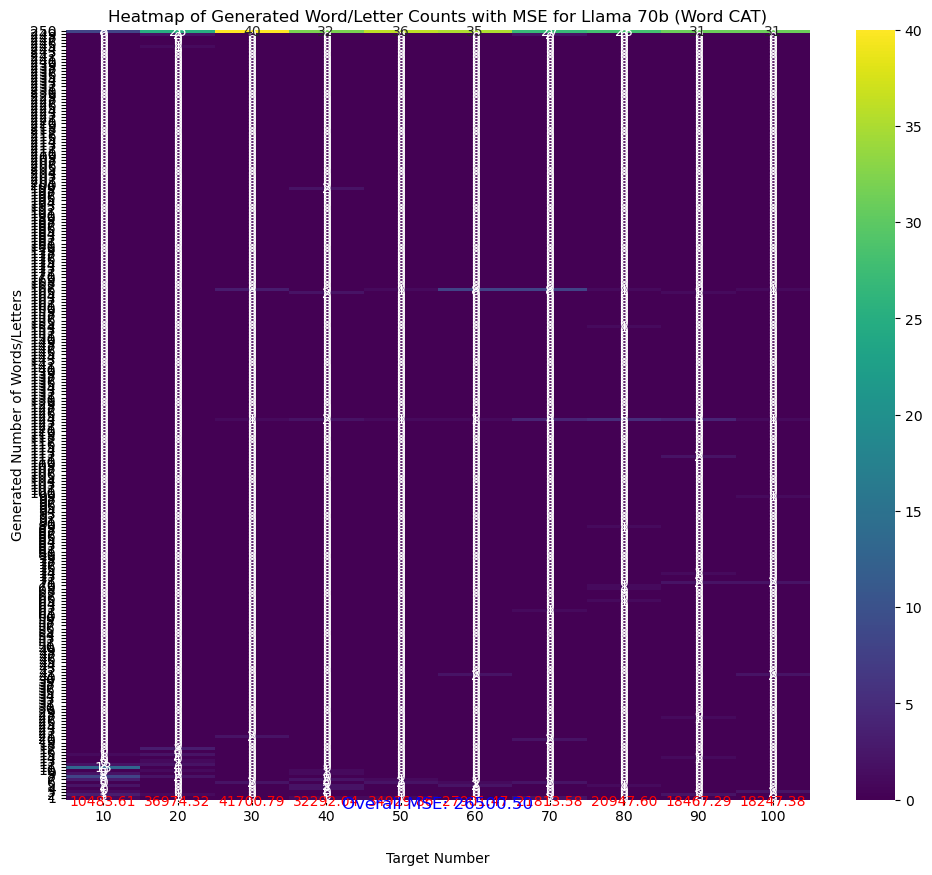

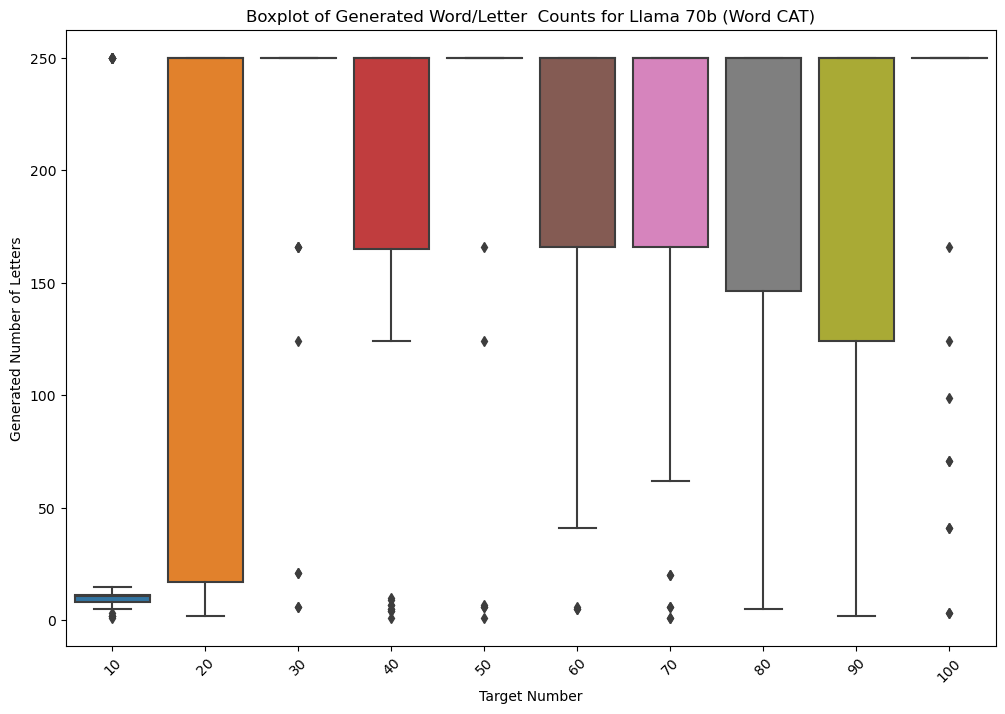

In [96]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cat = None  # Define or update this variable if needed
directory = r"C:\Users\Kaan\Desktop\thesis\mistral\generate\ollama_mistral_cat2_range100"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    answers = lines[3:]
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                    
                    # Store the generated numbers for each target number
                    gen_data[target_number].append(generated_num)
    
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = generated_num
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama70b_cat3_r10_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")

    return gen_data

def calculate_mse(data):
    mses = {}
    overall_squared_errors = []
    
    for target, counts in data.items():
        errors = [(count - target) ** 2 for count in counts]
        mses[target] = np.mean(errors) if errors else 0  # Handle division by zero
        overall_squared_errors.extend(errors)
    
    overall_mse = np.mean(overall_squared_errors) if overall_squared_errors else 0
    return mses, overall_mse

def create_heatmap_data(data):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum generated count across all data
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Set range to minimum 10 or maximum value if it exceeds 10
    range_limit = max(10, max_count)
    
    # Create bins from 1 to range_limit with bin size of 1
    bins = np.arange(1, range_limit + 2)  # "+2" ensures the last bin includes the max value
    bin_labels = [str(i) for i in range(1, range_limit + 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the generated counts and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap_with_mse(heatmap_data, target_numbers, bin_labels, mses, overall_mse, title):
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad=20)
    plt.ylabel('Generated Number of Words/Letters')
    plt.title(title)
    
    # Add MSE below each target number
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -0.5, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)
    
    # Add overall MSE at the bottom
    plt.text(len(target_numbers) / 2, -1.5, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', fontsize=12, color='blue')
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs for each target number and overall MSE
mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for word counts
word_heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data)

# Plot heatmap with MSEs
plot_heatmap_with_mse(word_heatmap_data, target_numbers, word_bin_labels, mses, overall_mse, 
                      'Heatmap of Generated Word/Letter Counts with MSE for Llama 70b (Word CAT)')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Letters', 'Boxplot of Generated Word/Letter  Counts for Llama 70b (Word CAT)')


### Letter Count 100

Data successfully saved to llama70b_cat1_r100_gen_data.csv


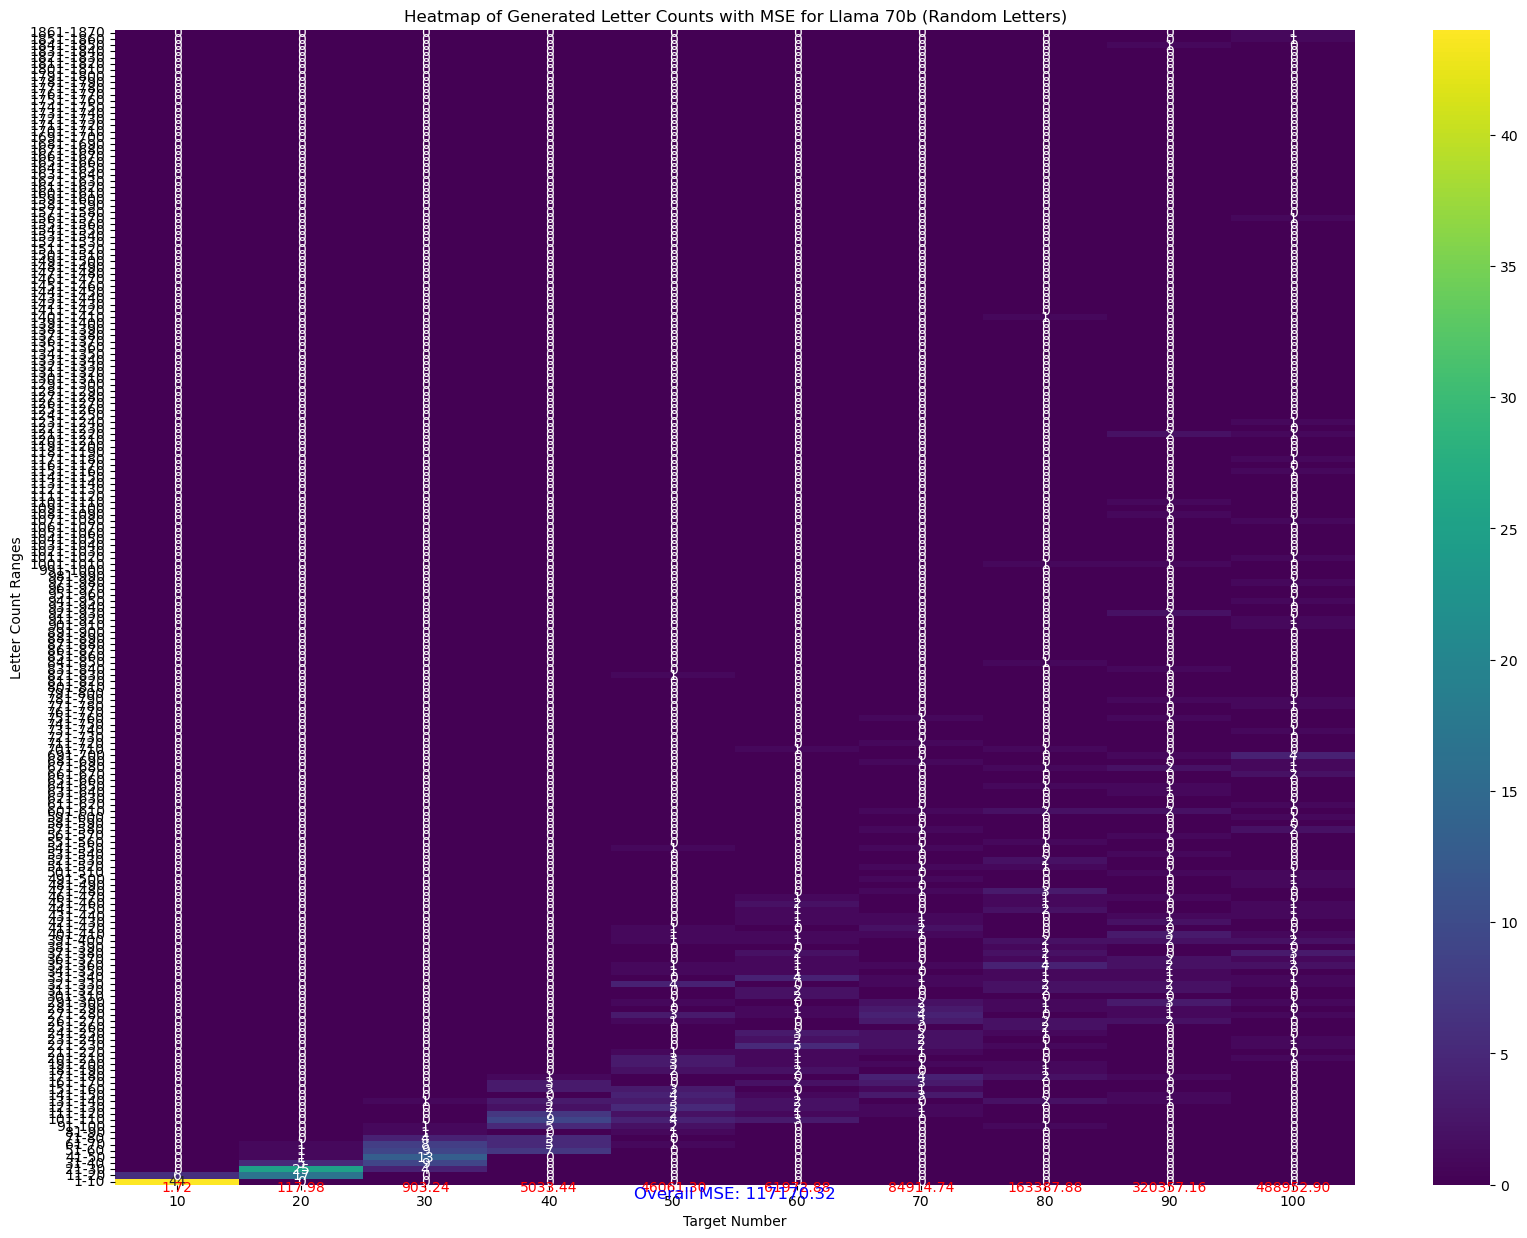

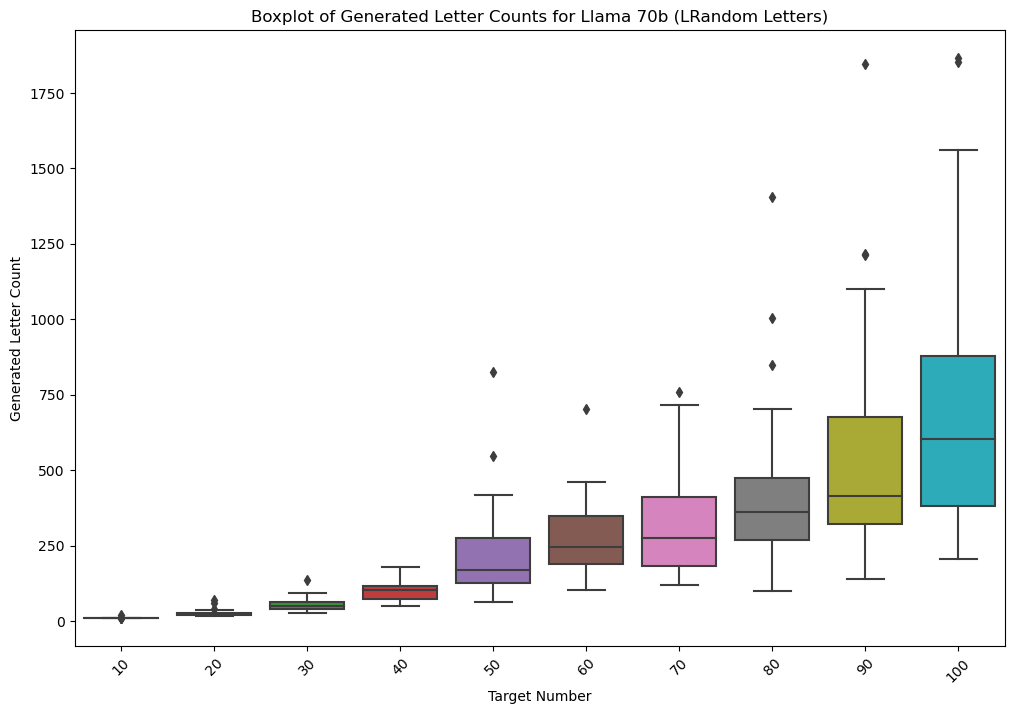

In [4]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

directory = r"C:\Users\Kaan\Desktop\thesis\llama3_70b\generate\llama3_70b_cat1_range100"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    generated_text = lines[3:]  # This should contain the generated text
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                    
                    # Count the letters in the generated text
                    letter_count = sum(len(line) for line in generated_text if line.strip())
                    
                    # Store the letter counts for each target number
                    gen_data[target_number].append(letter_count)
    
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = letter_count
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama70b_cat1_r100_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")
    return gen_data

def calculate_mse(data):
    mses = {}
    overall_squared_errors = []
    
    for target, counts in data.items():
        errors = [(count - target) ** 2 for count in counts]
        mses[target] = np.mean(errors) if errors else 0  # Handle division by zero
        overall_squared_errors.extend(errors)
    
    overall_mse = np.mean(overall_squared_errors) if overall_squared_errors else 0
    return mses, overall_mse

def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum word count to define the range for bins
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins with a minimum range of 100 or maximum value if it exceeds 100
    range_limit = max(100, max_count)
    bins = np.arange(1, range_limit + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the word counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap_with_mse(heatmap_data, target_numbers, bin_labels, mses, overall_mse, title):
    plt.figure(figsize=(20, 15))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Letter Count Ranges')
    plt.title(title)
    
    # Add MSE below each target number
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -0.5, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)
    
    # Add overall MSE at the bottom
    plt.text(len(target_numbers) / 2, -1.5, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', fontsize=12, color='blue')
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Letter Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Letter Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs for each target number and overall MSE
mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for letter counts
letter_heatmap_data, letter_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap with MSEs
plot_heatmap_with_mse(letter_heatmap_data, target_numbers, letter_bin_labels, mses, overall_mse, 
                      'Heatmap of Generated Letter Counts with MSE for Llama 70b (Random Letters)')

# Create boxplot data for letter counts
letter_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated letter counts
plot_boxplot(letter_df, 'Generated Letter Count', 'Boxplot of Generated Letter Counts for Llama 70b (LRandom Letters)')


### Letter Count (range 10)

Data successfully saved to llama70b_cat0_r10_gen_data.csv


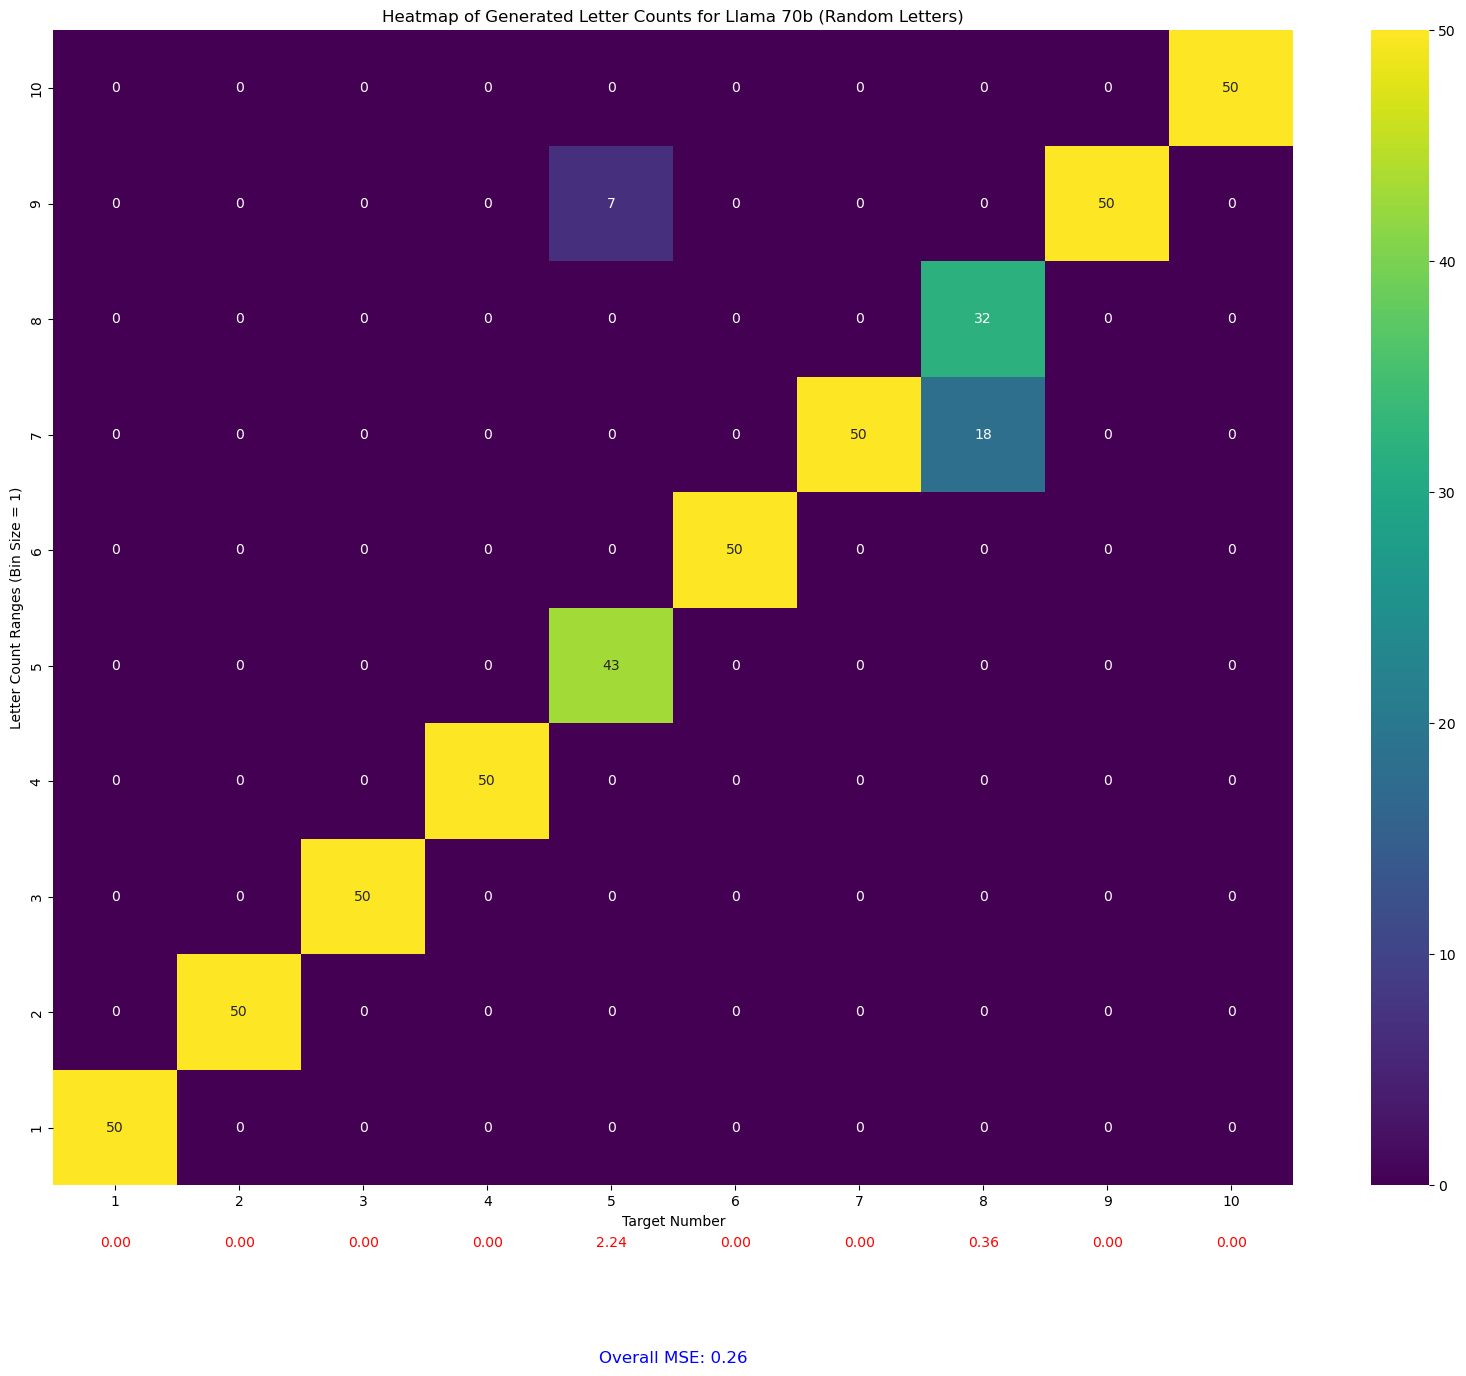

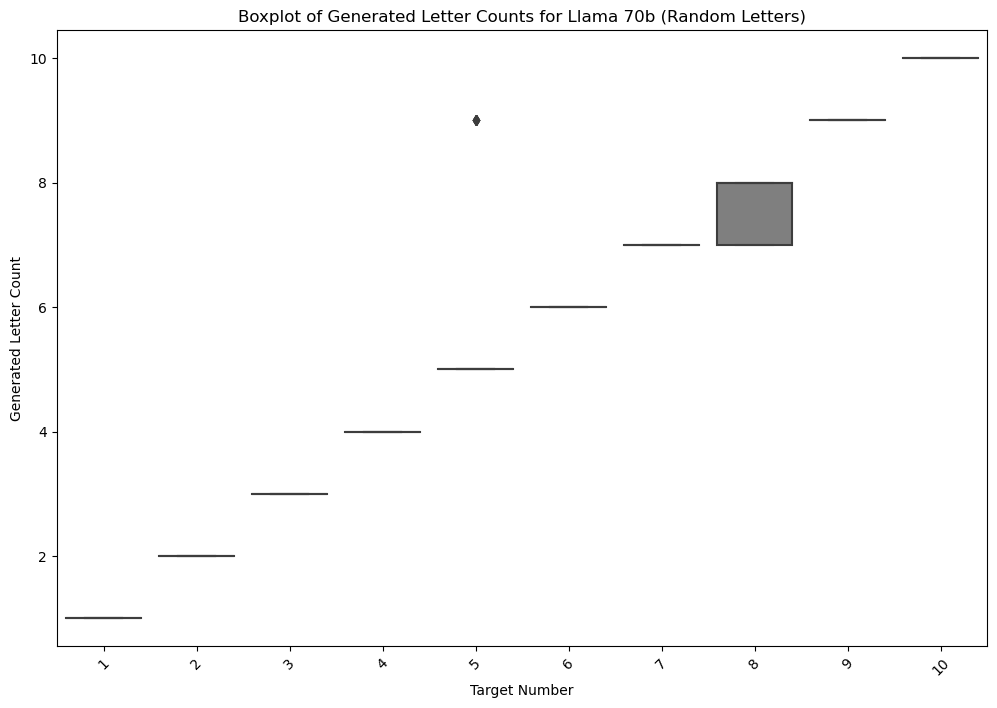

In [48]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

directory = r"C:\Users\Kaan\Desktop\thesis\llama3_70b\generate\llama3_70b_cat0_range10"

def process_files(directory):
    gen_data = defaultdict(list)
    
    # Change to the specified directory
    os.chdir(directory)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    generated_text = lines[3]  # This should contain the generated text
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                    
                    # Count the letters in the generated text
                    letter_count = len(generated_text)
                    
                    # Store the letter counts for each target number
                    gen_data[target_number].append(letter_count)
    
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = letter_count
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama70b_cat0_r10_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")
    return gen_data

def calculate_mse(data):
    mses = {}
    overall_squared_errors = []
    
    for target, counts in data.items():
        errors = [(count - target) ** 2 for count in counts]
        mses[target] = np.mean(errors) if errors else 0  # Handle division by zero
        overall_squared_errors.extend(errors)
    
    overall_mse = np.mean(overall_squared_errors) if overall_squared_errors else 0
    return mses, overall_mse

def create_heatmap_data(data, bin_size=1):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum letter count to define the range for bins
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)
    
    # Set bins from 1 to min(10, max_count), with bin size of 1
    range_limit = max(10, max_count)
    bins = np.arange(1, range_limit + bin_size + 1, bin_size)
    bin_labels = [str(i) for i in range(1, range_limit + 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the letter counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap_with_mse(heatmap_data, target_numbers, bin_labels, mses, overall_mse, title):
    plt.figure(figsize=(20, 15))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Letter Count Ranges (Bin Size = 1)')
    plt.title(title)
    
    # Add MSE below each target number
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -0.5, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)
    
    # Add overall MSE at the bottom
    plt.text(len(target_numbers) / 2, -1.5, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', fontsize=12, color='blue')
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Letter Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Letter Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs for each target number and overall MSE
mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for letter counts
letter_heatmap_data, letter_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=1)

# Plot heatmap with MSEs
plot_heatmap_with_mse(letter_heatmap_data, target_numbers, letter_bin_labels, mses, overall_mse, 
                      'Heatmap of Generated Letter Counts for Llama 70b (Random Letters)')

# Create boxplot data for letter counts
letter_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated letter counts
plot_boxplot(letter_df, 'Generated Letter Count', 'Boxplot of Generated Letter Counts for Llama 70b (Random Letters)')


# Llama8b (range 100)

## Words

### Words Range 10

Data successfully saved to llama8b_cat3_r10_gen_data.csv
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


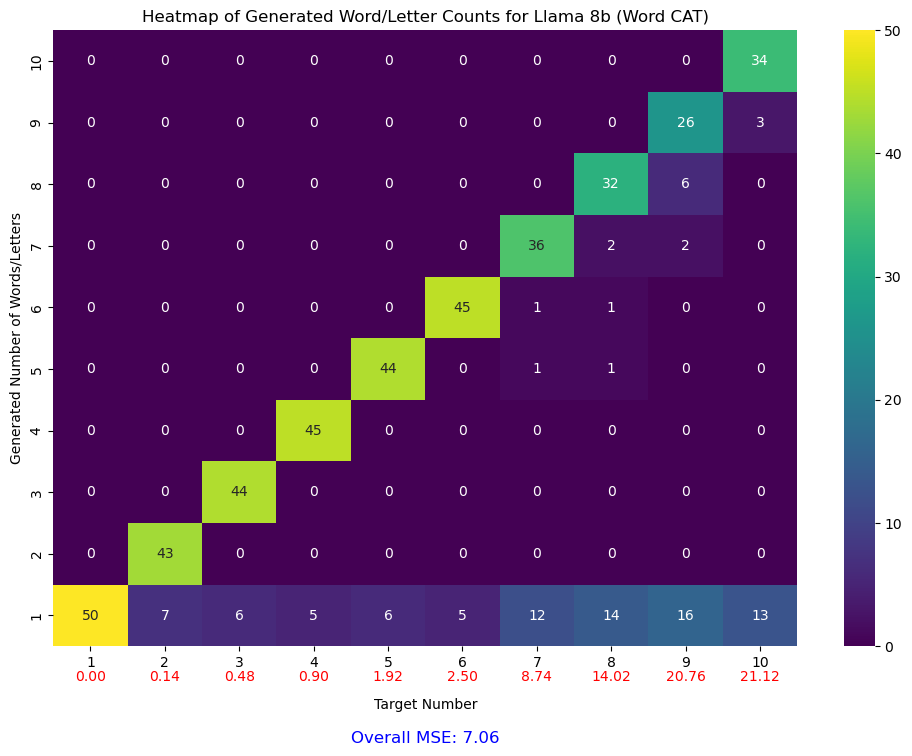

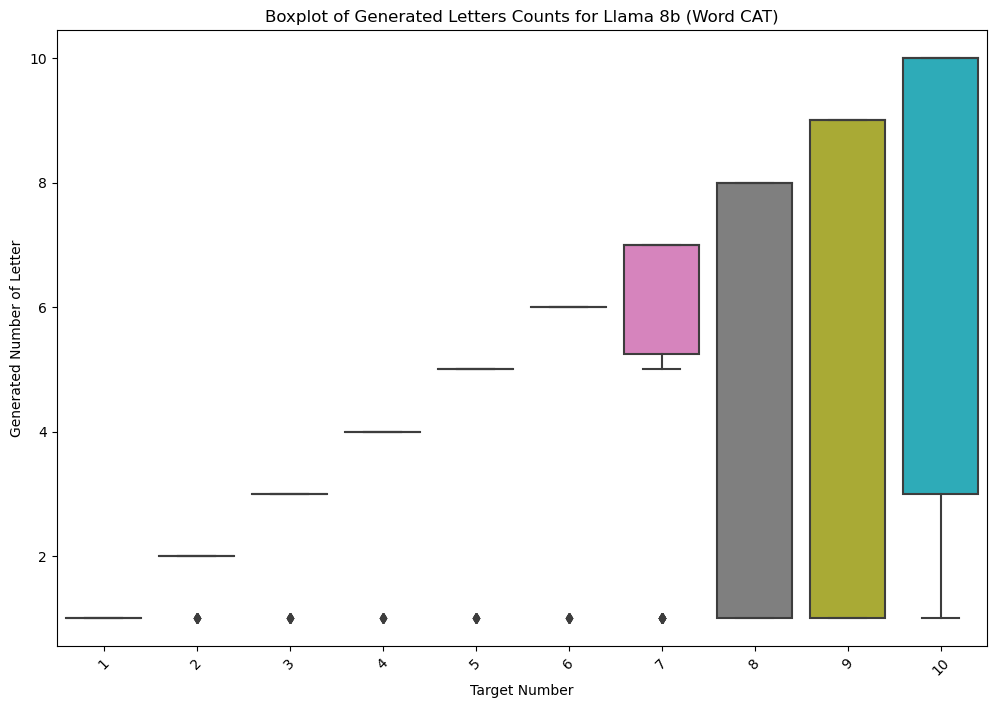

In [50]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

directory = r"C:\Users\Kaan\Desktop\thesis\llama3_8b\generate\llama3_8b_cat3_range10"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment    
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    answers = lines[3:]
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                    
                    # Store the generated numbers for each target number
                    gen_data[target_number].append(generated_num)
    
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = generated_num
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama8b_cat3_r10_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")
    return gen_data

def calculate_mse(data):
    mses = {}
    overall_squared_errors = []
    
    for target, counts in data.items():
        errors = [(count - target) ** 2 for count in counts]
        mses[target] = np.mean(errors) if errors else 0  # Handle division by zero
        overall_squared_errors.extend(errors)
    
    overall_mse = np.mean(overall_squared_errors) if overall_squared_errors else 0
    return mses, overall_mse

def create_heatmap_data(data):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    print(target_numbers)
    
    # Get the maximum generated count across all data
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins from 1 to max_count with bin size of 1
    bins = np.arange(1, max_count + 2)  # "+2" ensures the last bin includes the max value
    bin_labels = [str(i) for i in range(1, max_count + 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the generated counts and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap_with_mse(heatmap_data, target_numbers, bin_labels, mses, overall_mse, title):
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad= 20)
    plt.ylabel('Generated Number of Words/Letters')
    plt.title(title)
    
    # Add MSE below each target number
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -0.5, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)
    
    # Add overall MSE at the bottom
    plt.text(len(target_numbers) / 2, -1.5, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', fontsize=12, color='blue')
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs for each target number and overall MSE
mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for word counts with bin size of 1
word_heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data)

# Plot heatmap of the generated word counts with MSEs
plot_heatmap_with_mse(word_heatmap_data, target_numbers, word_bin_labels, mses, overall_mse, 
                      'Heatmap of Generated Word/Letter Counts for Llama 8b (Word CAT)')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Letter', 'Boxplot of Generated Letters Counts for Llama 8b (Word CAT)')


### Words range 100

Data successfully saved to llama8b_cat2_r100_gen_data.csv


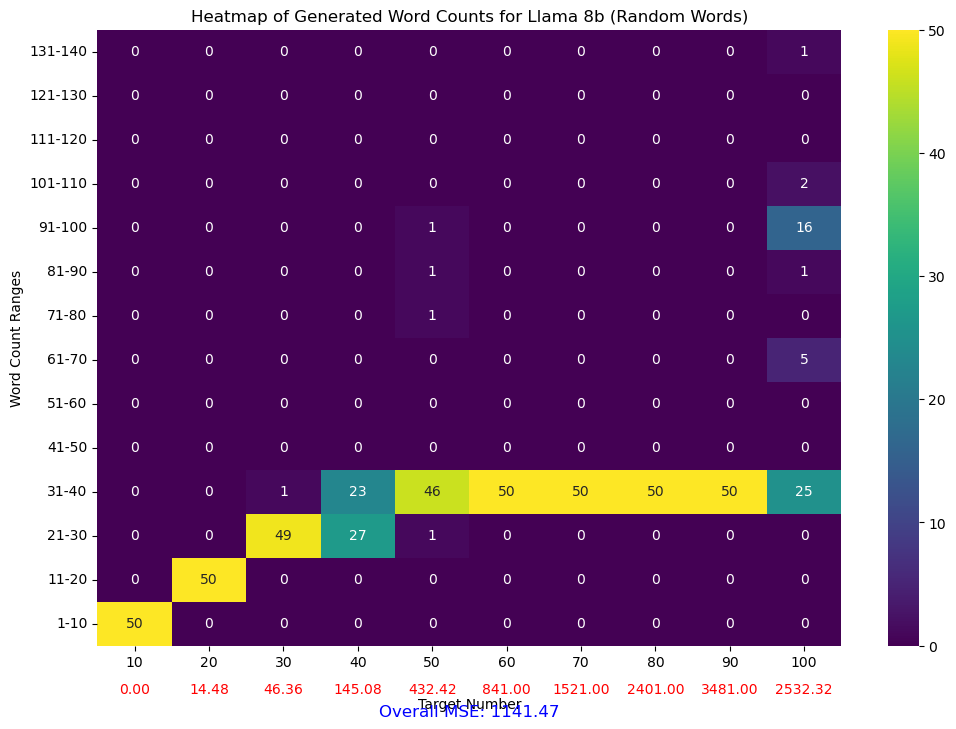

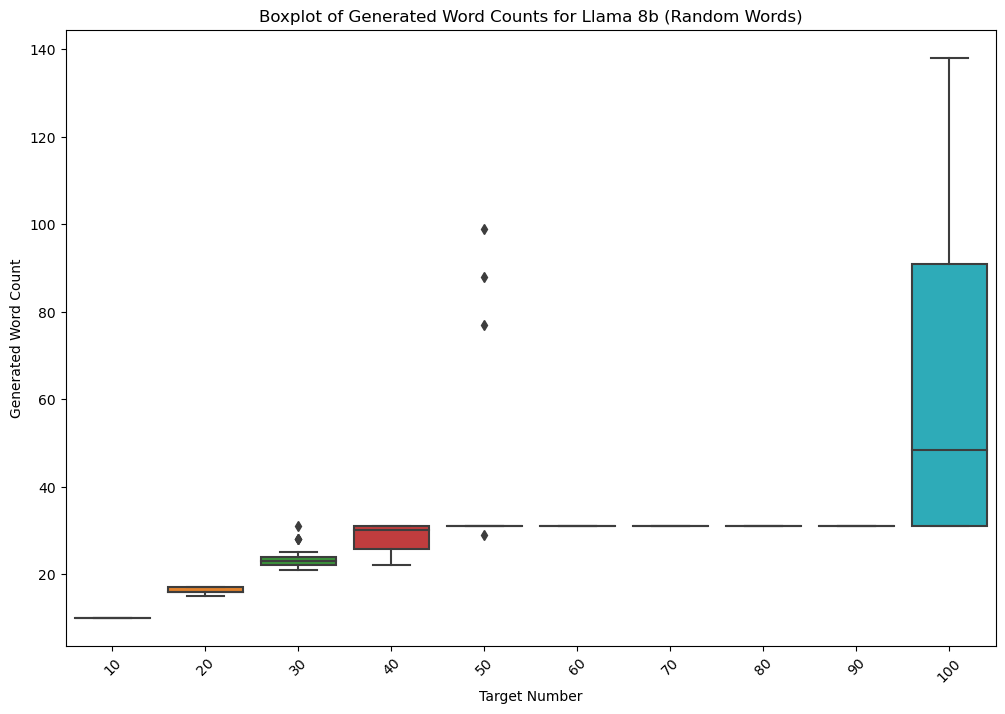

In [52]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

directory = r"C:\Users\Kaan\Desktop\thesis\llama3_8b\generate\llama3_8b_cat2"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment 
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_text = " ".join(lines[2:]).strip()
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    
                    # Count the number of words in the generated text
                    word_count = len(generated_text.split())
                    
                    # Store the word counts for each target number
                    gen_data[target_number].append(word_count)
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = word_count
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama8b_cat2_r100_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")
    return gen_data

def calculate_mse(data):
    mses = {}
    overall_squared_errors = []
    
    for target, counts in data.items():
        errors = [(count - target) ** 2 for count in counts]
        mses[target] = np.mean(errors) if errors else 0  # Handle empty list case
        overall_squared_errors.extend(errors)
    
    overall_mse = np.mean(overall_squared_errors) if overall_squared_errors else 0
    return mses, overall_mse

def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum word count to define the range for bins
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins of equal size, starting from 1 to max_count, in steps of bin_size
    bins = np.arange(1, max_count + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the word counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap_with_mse(heatmap_data, target_numbers, bin_labels, mses, overall_mse, title):
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad= 20)
    plt.ylabel('Word Count Ranges')
    plt.title(title)
    
    # Add MSE below each target number
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -1, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)
    
    # Add overall MSE at the bottom
    plt.text(len(target_numbers) / 2, -1.5, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', fontsize=12, color='blue')
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Word Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Word Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs for each target number and overall MSE
mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for word counts with equal bin size of 10
word_heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap of the generated word counts with MSEs
plot_heatmap_with_mse(word_heatmap_data, target_numbers, word_bin_labels, mses, overall_mse, 
                      'Heatmap of Generated Word Counts for Llama 8b (Random Words)')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Word Count', 'Boxplot of Generated Word Counts for Llama 8b (Random Words)')


## Letters

### Letters range 10

Data successfully saved to llama8b_cat0_r10_gen_data.csv


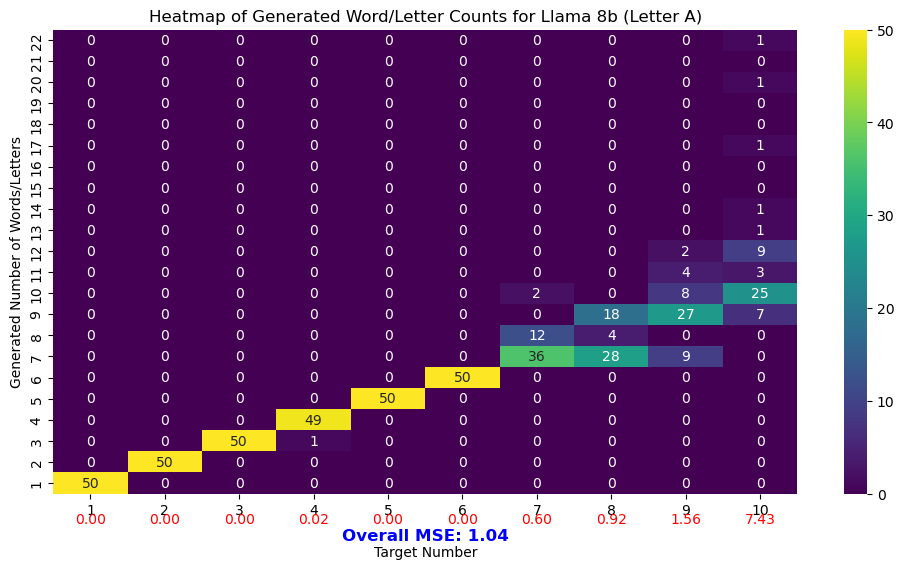

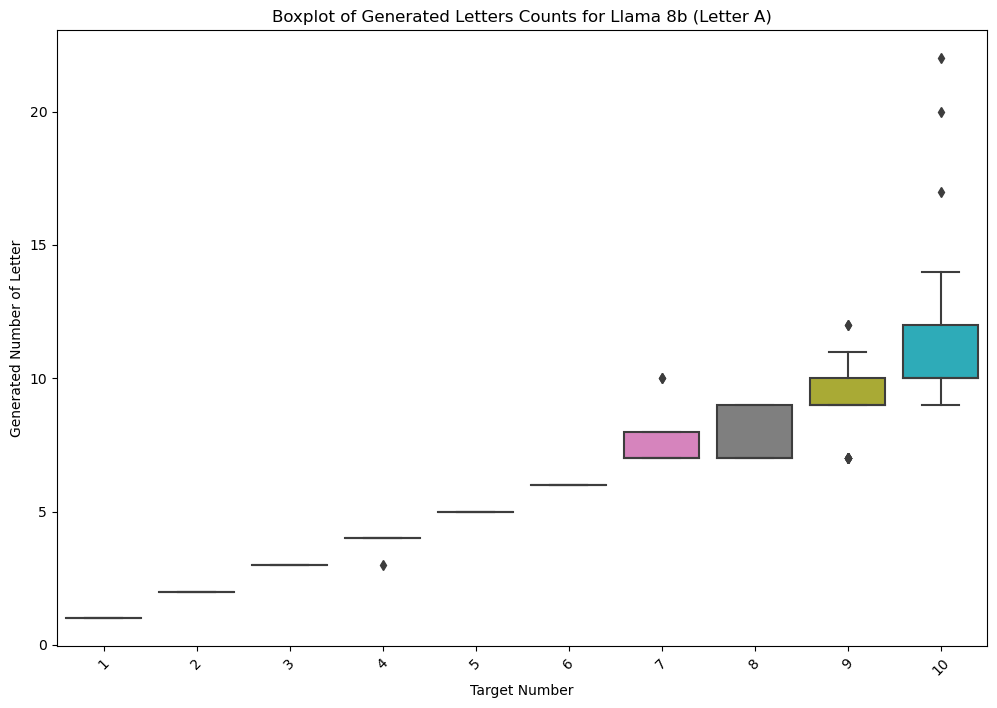

In [55]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set your directory here
directory = r"C:\Users\Kaan\Desktop\thesis\llama3_8b\generate\llama3_8b_cat0_range10"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment    
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    answers = lines[3:]
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                    
                    # Store the generated numbers for each target number
                    gen_data[target_number].append(generated_num)
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = generated_num
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama8b_cat0_r10_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")    
    return gen_data

def calculate_mse(data):
    individual_mses = {}
    all_errors = []
    
    for target, generated_numbers in data.items():
        errors = np.array(generated_numbers) - target
        mse = np.mean(errors ** 2)
        individual_mses[target] = mse
        all_errors.extend(errors)
    
    # Calculate overall MSE
    overall_mse = np.mean(np.array(all_errors) ** 2)
    return individual_mses, overall_mse

def create_heatmap_data(data):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum generated count across all data
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins from 1 to max_count with bin size of 1
    bins = np.arange(1, max_count + 2)  # "+2" ensures the last bin includes the max value
    bin_labels = [str(i) for i in range(1, max_count + 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the generated counts and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap(heatmap_data, target_numbers, bin_labels, title, mses, overall_mse):
    plt.figure(figsize=(12, 8))
    
    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad= 20)
    plt.ylabel('Generated Number of Words/Letters')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin

    # Add individual MSE annotations below the heatmap
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -1.2, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)

    # Add overall MSE annotation below all individual MSEs
    plt.text(len(target_numbers) / 2, -2.0, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', color='blue', fontsize=12, fontweight='bold')

    # Adjust the bottom margin to ensure annotations are visible
    plt.subplots_adjust(bottom=0.3)
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs
individual_mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for word counts with bin size of 1
word_heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data)

# Plot heatmap of the generated word counts with MSE annotations
plot_heatmap(word_heatmap_data, target_numbers, word_bin_labels, 
             'Heatmap of Generated Word/Letter Counts for Llama 8b (Letter A)', individual_mses, overall_mse)

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Letter', 'Boxplot of Generated Letters Counts for Llama 8b (Letter A)')


### Letters Range 100

Data successfully saved to llama8b_cat1_r100_gen_data.csv


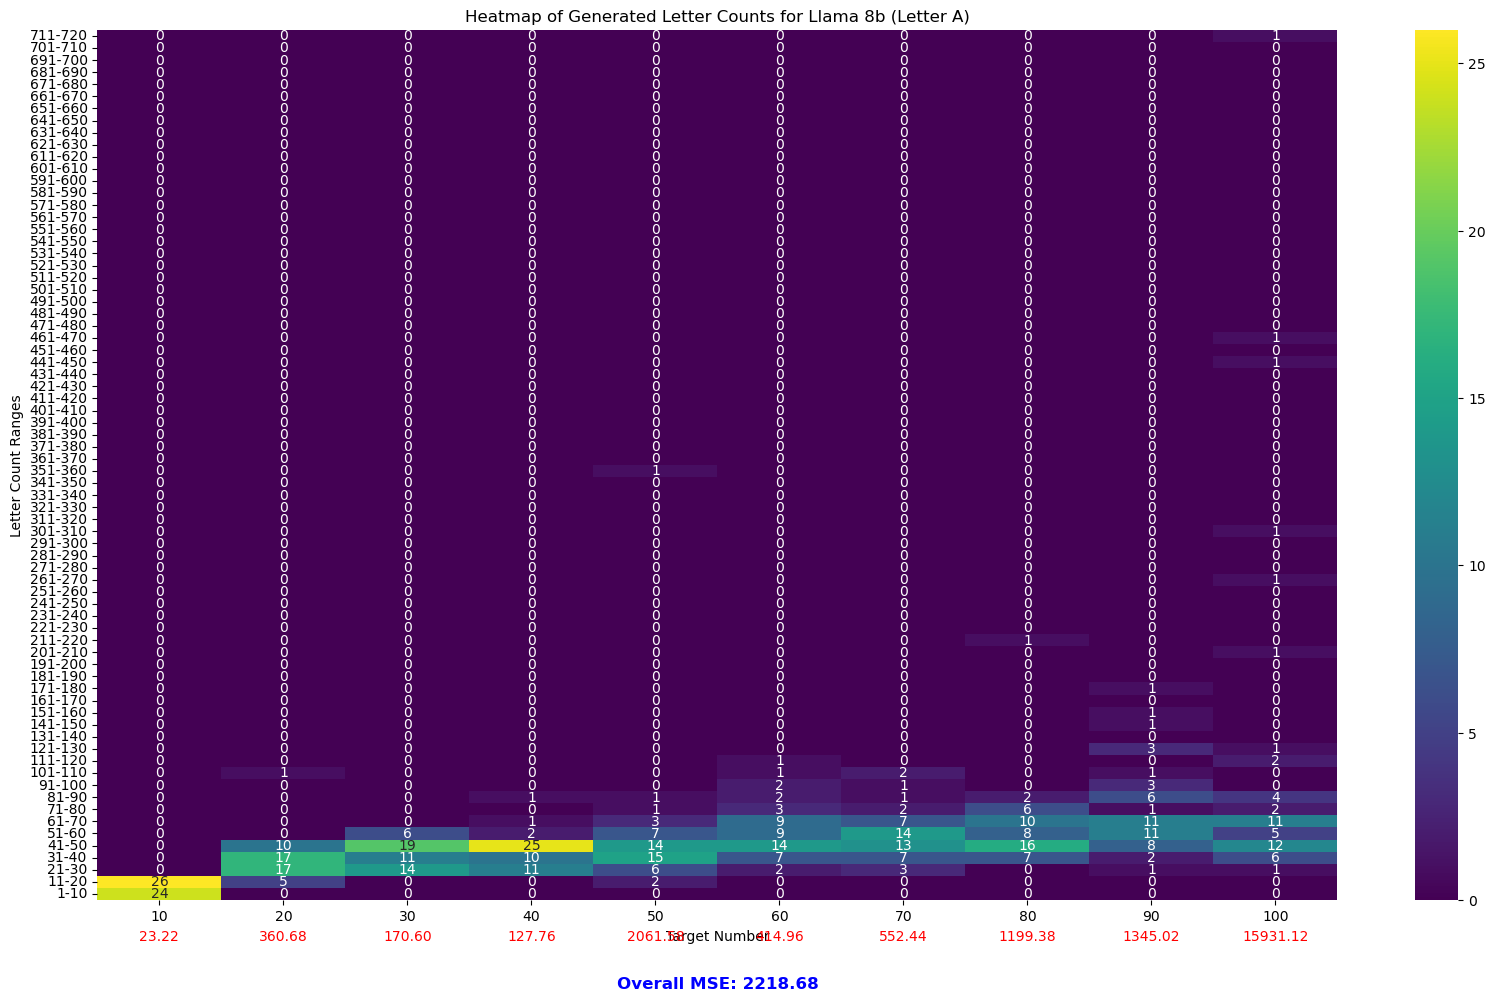

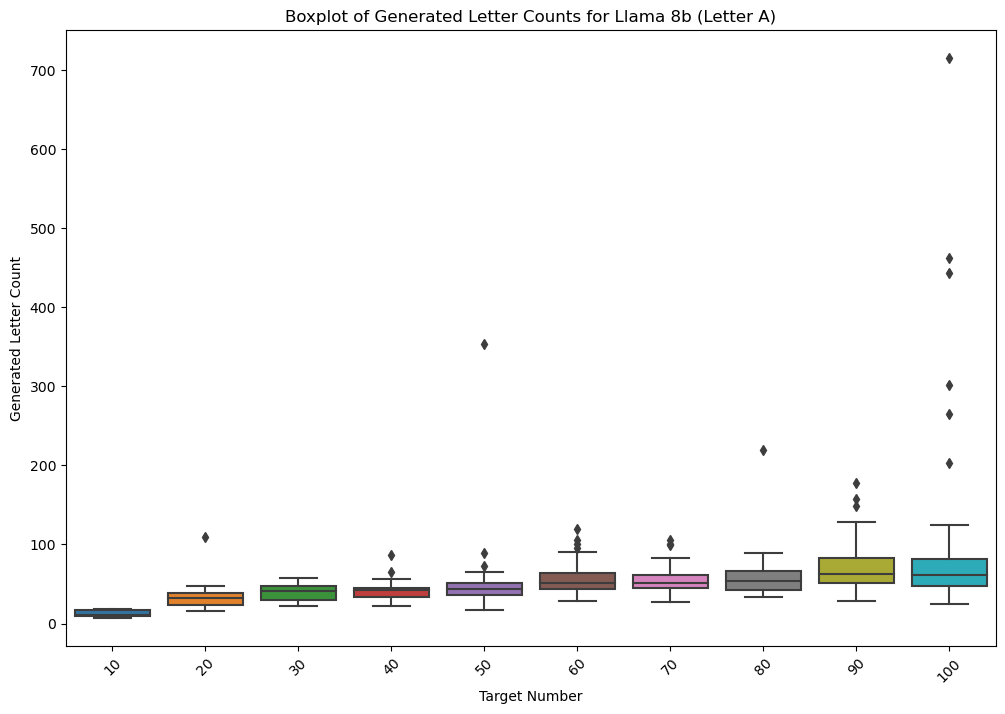

In [57]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set your directory
directory = r"C:\Users\Kaan\Desktop\thesis\llama3_8b\generate\llama3_8b_cat1"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment    
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_text = " ".join(lines[2:]).strip()
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    
                    # Count the letters in the generated text
                    letter_count = len(generated_text)
                    
                    # Store the letter counts for each target number
                    gen_data[target_number].append(letter_count)
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = letter_count
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama8b_cat1_r100_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")       
    return gen_data

def calculate_mse(data):
    individual_mses = {}
    all_errors = []
    
    for target, generated_counts in data.items():
        errors = np.array(generated_counts) - target
        mse = np.mean(errors ** 2)
        individual_mses[target] = mse
        all_errors.extend(errors)
    
    # Calculate overall MSE
    overall_mse = np.mean(np.array(all_errors) ** 2)
    return individual_mses, overall_mse

def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum word count to define the range for bins
    all_counts = [count for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins of equal size, starting from 1 to max_count, in steps of bin_size
    bins = np.arange(1, max_count + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the word counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for count in data[target]:
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

def plot_heatmap(heatmap_data, target_numbers, bin_labels, title, mses, overall_mse):
    plt.figure(figsize=(20, 15))
    
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Letter Count Ranges')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have zeros at the origin

    # Add individual MSE annotations below the heatmap
    for i, target in enumerate(target_numbers):
        plt.text(i + 0.5, -3, f"{mses[target]:.2f}", ha='center', va='center', color='red', fontsize=10)

    # Add overall MSE annotation below all individual MSEs
    plt.text(len(target_numbers) / 2, -7.0, f"Overall MSE: {overall_mse:.2f}", ha='center', va='center', color='blue', fontsize=12, fontweight='bold')

    # Adjust the bottom margin to ensure annotations are visible
    plt.subplots_adjust(bottom=0.3)
    plt.show()

def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count))
    
    df = pd.DataFrame(records, columns=['Target Number', 'Letter Count'])
    return df

def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Letter Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSEs
individual_mses, overall_mse = calculate_mse(gen_data)

# Create heatmap data for letter counts with equal bin size of 10
letter_heatmap_data, letter_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap of the generated letter counts with MSE annotations
plot_heatmap(letter_heatmap_data, target_numbers, letter_bin_labels, 
             'Heatmap of Generated Letter Counts for Llama 8b (Letter A)', individual_mses, overall_mse)

# Create boxplot data for letter counts
letter_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated letter counts
plot_boxplot(letter_df, 'Generated Letter Count', 'Boxplot of Generated Letter Counts for Llama 8b (Letter A)')


# Mistral

### Word count 100

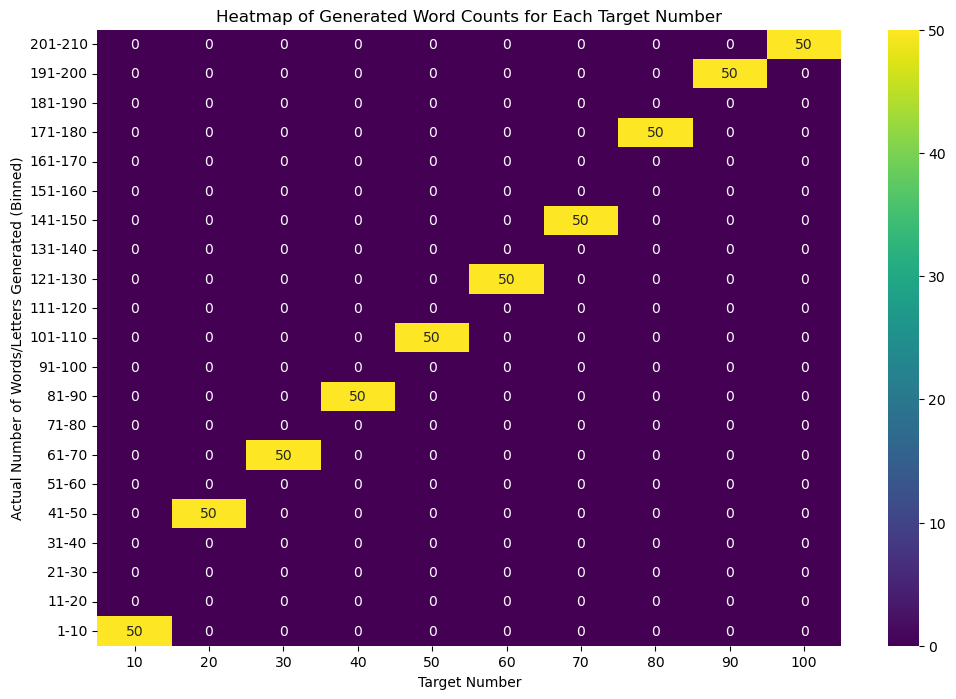

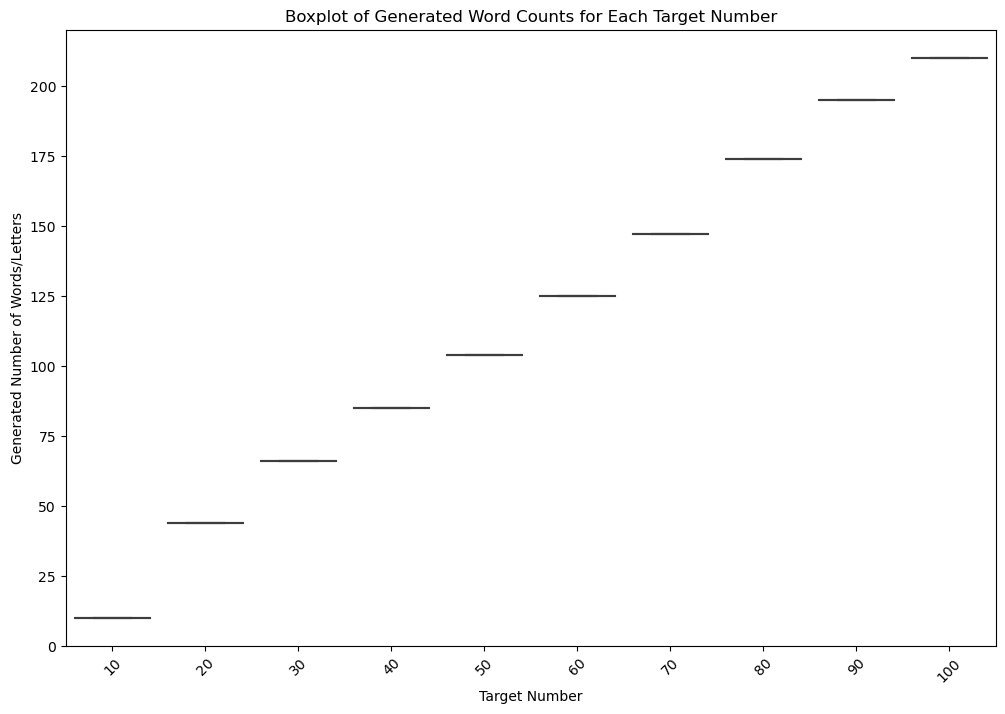

In [ ]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the directory path containing your text files
directory = r"C:\Users\Kaan\Desktop\thesis\mistral\mistral_cat3_range100"

# Function to process files and extract the target number and generated counts
def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: \d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    
                    # Extracting target number, trial, generated number, and answers
                    target_line = lines[0]  # 'Target number: X'
                    trial_line = lines[1]  # 'Trial: X'
                    generated_num_line = lines[2]  # 'Generated num: X'
                    answers = lines[3:]  # The words/letters generated
                    
                    # Extract the target number and generated num
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num: (\d+)', generated_num_line).group(1))
                    
                    # Process the answers (comma-separated words or letters)
                    answer_text = " ".join(answers)  # Combine all lines of answers
                    words = re.findall(r'\b\w+\b', answer_text)  # Extract words/letters
                    
                    # Store the generated numbers and actual word count for each target number
                    gen_data[target_number].append({
                        'generated_num': generated_num,
                        'actual_count': len(words)  # Count the number of words or letters
                    })
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = len(words)
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "mistral_cat3_r100_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")      
    return gen_data

# Create heatmap data by binning actual counts with a bin size of 10
def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum actual count across all data to determine bin range
    all_counts = [count['actual_count'] for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins starting from 1, with a bin size of 10, up to the maximum count
    bins = np.arange(1, max_count + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the actual counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for result in data[target]:
            count = result['actual_count']
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

# Plot heatmap
def plot_heatmap(heatmap_data, target_numbers, bin_labels, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Actual Number of Words/Letters Generated (Binned)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have smaller values near the origin
    plt.show()

# Convert the dictionary into a DataFrame for boxplot
def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count['actual_count']))  # Store the actual count
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

# Plot boxplot
def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Create heatmap data for word counts with bin size of 10
heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap of the generated word counts
plot_heatmap(heatmap_data, target_numbers, word_bin_labels, 'Heatmap of Generated Word Counts for Each Target Number')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Words/Letters', 'Boxplot of Generated Word Counts for Each Target Number')


### Word count 10

In [59]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the directory path containing your text files
directory = r"C:\Users\Kaan\Desktop\thesis\mistral\generate\ollama_mistral_cat3_range10"

# Function to process files and extract the target number and generated counts
def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment        
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: \d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    
                    # Extracting target number, trial, generated number, and answers
                    target_line = lines[0]  # 'Target number: X'
                    trial_line = lines[1]  # 'Trial: X'
                    generated_num_line = lines[2]  # 'Generated num: X'
                    answers = lines[3:]  # The words/letters generated
                    
                    # Extract the target number and generated num
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num: (\d+)', generated_num_line).group(1))
                    
                    # Process the answers (comma-separated words or letters)
                    answer_text = " ".join(answers)  # Combine all lines of answers
                    words = re.findall(r'\b\w+\b', answer_text)  # Extract words/letters
                    
                    # Store the generated numbers and actual word count for each target number
                    gen_data[target_number].append({
                        'generated_num': generated_num,
                        'actual_count': len(words)  # Count the number of words or letters
                    })
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = len(words)
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "mistral_cat3_r10_gen_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")      
    return gen_data

# Create heatmap data by binning actual counts with a bin size of 1
def create_heatmap_data(data, bin_size=1):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum actual count across all data to determine bin range
    all_counts = [count['actual_count'] for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins starting from 1, with a bin size of 1, up to the maximum count
    bins = np.arange(1, max_count + bin_size, bin_size)
    bin_labels = [f"{int(bins[i])}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the actual counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for result in data[target]:
            count = result['actual_count']
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

# Plot heatmap
def plot_heatmap(heatmap_data, target_numbers, bin_labels, title):
    plt.figure(figsize=(15, 12))
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Actual Number of Words/Letters Generated (Binned)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have smaller values near the origin
    plt.show()

# Convert the dictionary into a DataFrame for boxplot
def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count['actual_count']))  # Store the actual count
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

# Plot boxplot
def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Create heatmap data for word counts with bin size of 1
heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=1)

# Plot heatmap of the generated word counts
plot_heatmap(heatmap_data, target_numbers, word_bin_labels, 'Heatmap of Generated Word Counts for Each Target Number (Bin Size = 1)')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Words/Letters', 'Boxplot of Generated Word Counts for Each Target Number')


Data successfully saved to mistral_cat3_r10_gen_data.csv


ValueError: max() arg is an empty sequence

### Letter count 100

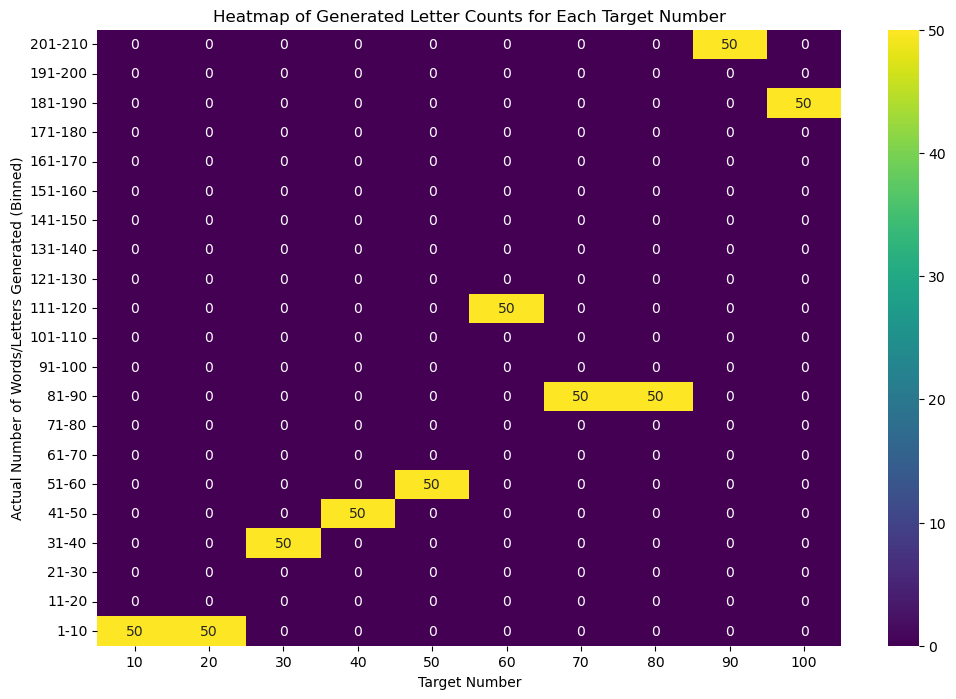

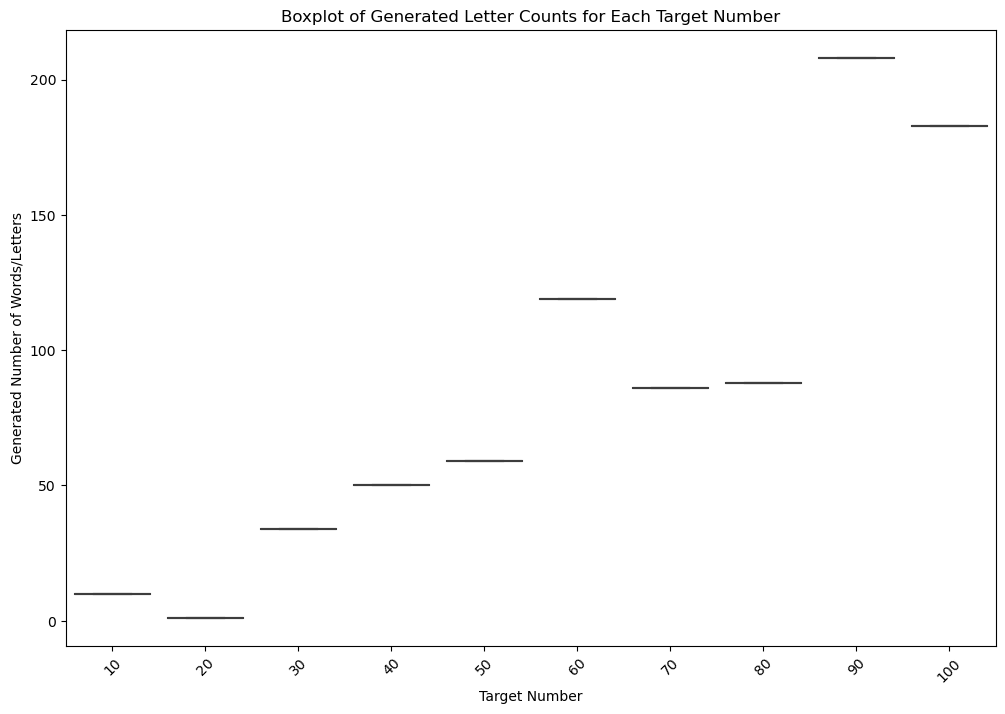

In [45]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the directory path containing your text files
directory = r"C:\Users\Kaan\Desktop\thesis\mistral\mistral_cat1_range100"

# Function to process files and extract the target number and generated counts
def process_files(directory):
    gen_data = defaultdict(list)
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: \d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    
                    # Extracting target number, trial, generated number, and answers
                    target_line = lines[0]  # 'Target number: X'
                    trial_line = lines[1]  # 'Trial: X'
                    generated_num_line = lines[2]  # 'Generated num: X'
                    answers = lines[3:]  # The words/letters generated
                    
                    # Extract the target number and generated num
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num: (\d+)', generated_num_line).group(1))
                    
                    # Process the answers (comma-separated words or letters)
                    answer_text = " ".join(answers)  # Combine all lines of answers
                    words = re.findall(r'\b\w+\b', answer_text)  # Extract words/letters
                    
                    # Store the generated numbers and actual word count for each target number
                    gen_data[target_number].append({
                        'generated_num': generated_num,
                        'actual_count': len(words)  # Count the number of words or letters
                    })
    
    return gen_data

# Create heatmap data by binning actual counts with a bin size of 10
def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum actual count across all data to determine bin range
    all_counts = [count['actual_count'] for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins starting from 1, with a bin size of 10, up to the maximum count
    bins = np.arange(1, max_count + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the actual counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for result in data[target]:
            count = result['actual_count']
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

# Plot heatmap
def plot_heatmap(heatmap_data, target_numbers, bin_labels, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Actual Number of Words/Letters Generated (Binned)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have smaller values near the origin
    plt.show()

# Convert the dictionary into a DataFrame for boxplot
def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count['actual_count']))  # Store the actual count
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

# Plot boxplot
def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Create heatmap data for word counts with bin size of 10
heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap of the generated word counts
plot_heatmap(heatmap_data, target_numbers, word_bin_labels, 'Heatmap of Generated Letter Counts for Each Target Number')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Words/Letters', 'Boxplot of Generated Letter Counts for Each Target Number')


### Letter count 10

In [8]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the directory path containing your text files
directory = r"C:\Users\Kaan\Desktop\thesis\mistral\mistral_cat1_range10"

# Function to process files and extract the target number and generated counts
def process_files(directory):
    gen_data = defaultdict(list)
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: \d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    
                    # Extracting target number, trial, generated number, and answers
                    target_line = lines[0]  # 'Target number: X'
                    trial_line = lines[1]  # 'Trial: X'
                    generated_num_line = lines[2]  # 'Generated num: X'
                    answers = lines[3:]  # The words/letters generated
                    
                    # Extract the target number and generated num
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num: (\d+)', generated_num_line).group(1))
                    
                    # Process the answers (comma-separated words or letters)
                    answer_text = " ".join(answers)  # Combine all lines of answers
                    words = re.findall(r'\b\w+\b', answer_text)  # Extract words/letters
                    
                    # Store the generated numbers and actual word count for each target number
                    gen_data[target_number].append({
                        'generated_num': generated_num,
                        'actual_count': len(words)  # Count the number of words or letters
                    })
    
    return gen_data

# Create heatmap data by binning actual counts with a bin size of 1
def create_heatmap_data(data, bin_size=1):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the maximum actual count across all data to determine bin range
    all_counts = [count['actual_count'] for counts in data.values() for count in counts]
    max_count = max(all_counts)

    # Create bins starting from 1, with a bin size of 1, up to the maximum count
    bins = np.arange(1, max_count + bin_size, bin_size)
    bin_labels = [f"{int(bins[i])}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the actual counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for result in data[target]:
            count = result['actual_count']
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if bin_index >= len(bins) - 1:
                bin_index = len(bins) - 2  # Handle edge case where count equals the upper bin edge
            heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

# Plot heatmap
def plot_heatmap(heatmap_data, target_numbers, bin_labels, title):
    plt.figure(figsize=(15, 12))
    sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number')
    plt.ylabel('Actual Number of Words/Letters Generated (Binned)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have smaller values near the origin
    plt.show()

# Convert the dictionary into a DataFrame for boxplot
def create_boxplot_data(data):
    # Convert the dictionary into a DataFrame
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count['actual_count']))  # Store the actual count
    
    df = pd.DataFrame(records, columns=['Target Number', 'Actual Count'])
    return df

# Plot boxplot
def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='Actual Count', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Create heatmap data for word counts with bin size of 1
heatmap_data, word_bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=1)

# Plot heatmap of the generated word counts
plot_heatmap(heatmap_data, target_numbers, word_bin_labels, 'Heatmap of Generated Letter Counts for Each Target Number (Bin Size = 1)')

# Create boxplot data for word counts
word_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated word counts
plot_boxplot(word_df, 'Generated Number of Words/Letters', 'Boxplot of Generated Letter Counts for Each Target Number')


ValueError: max() arg is an empty sequence

# Grouping

## Heatmap

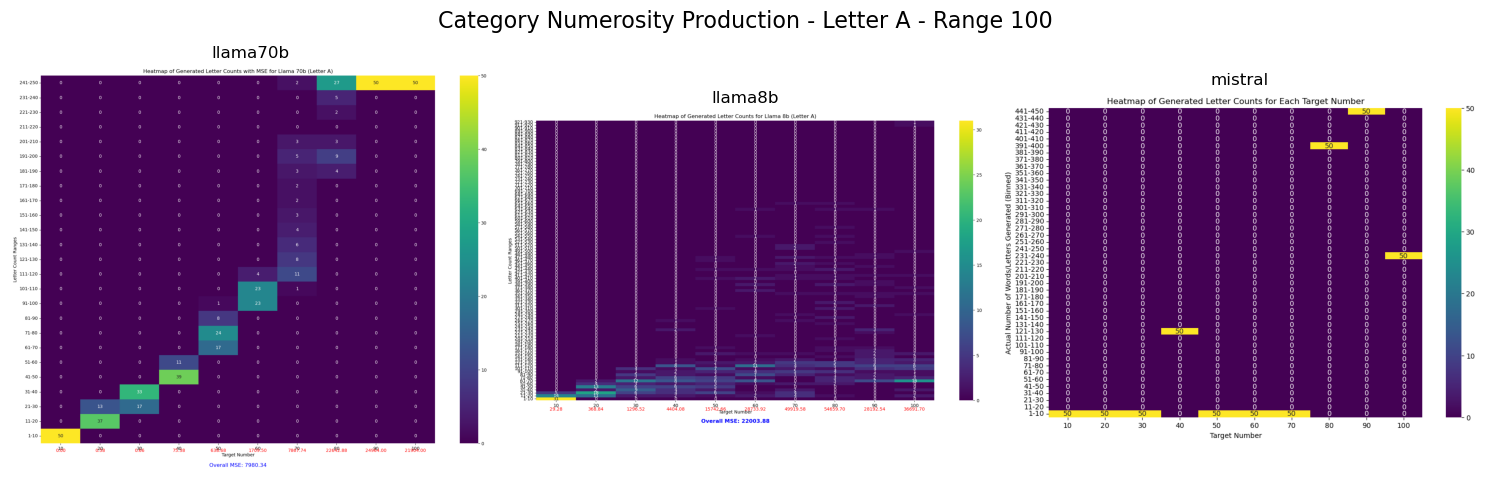

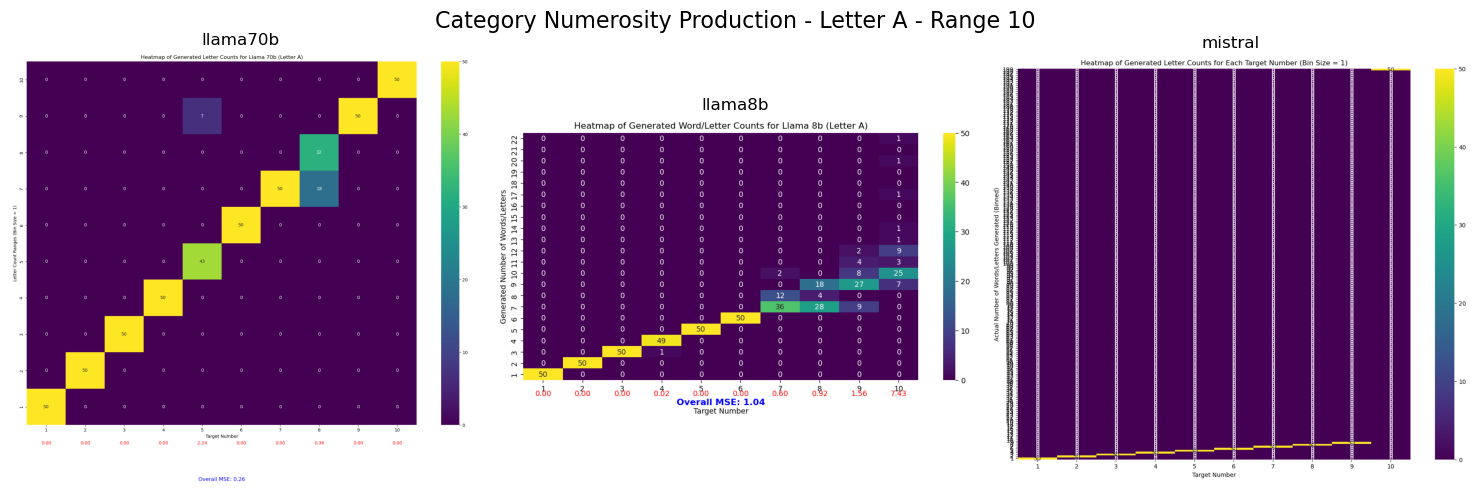

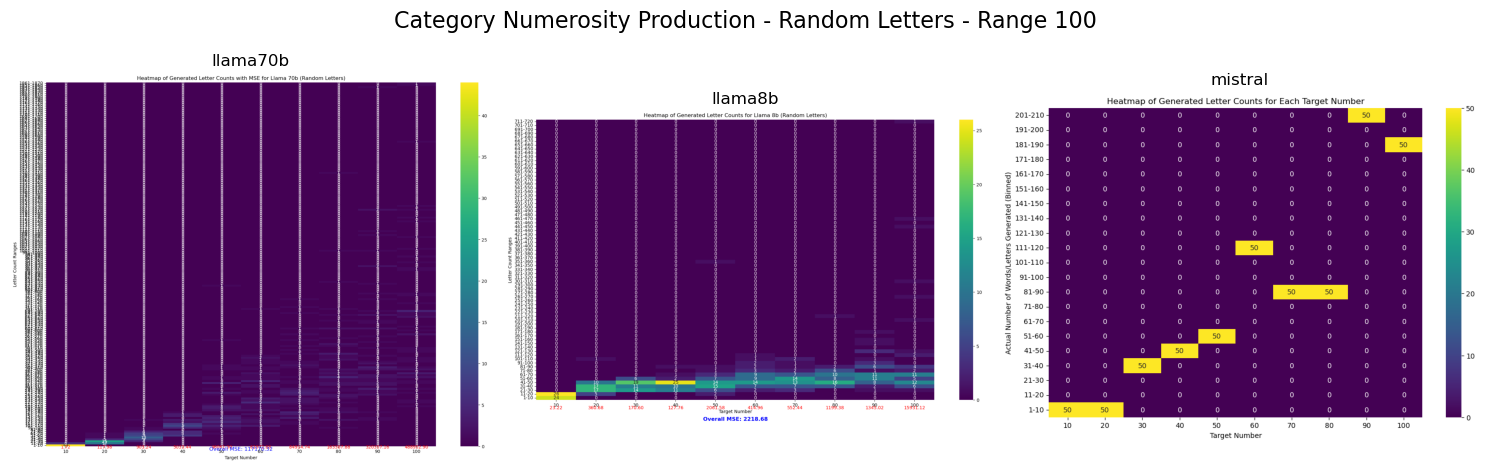

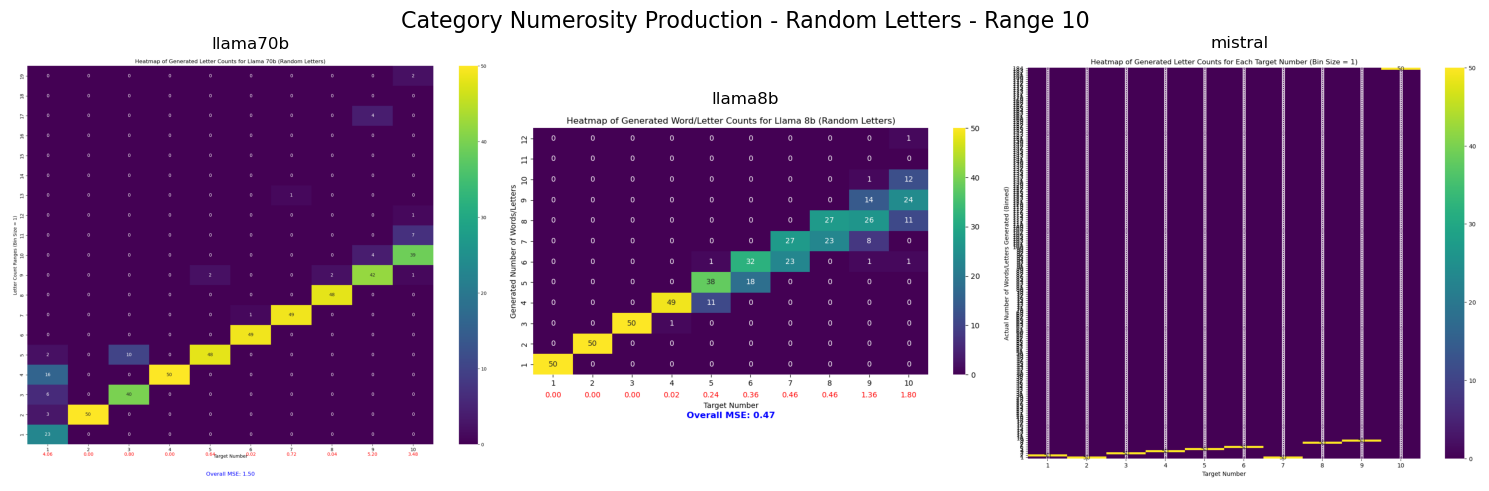

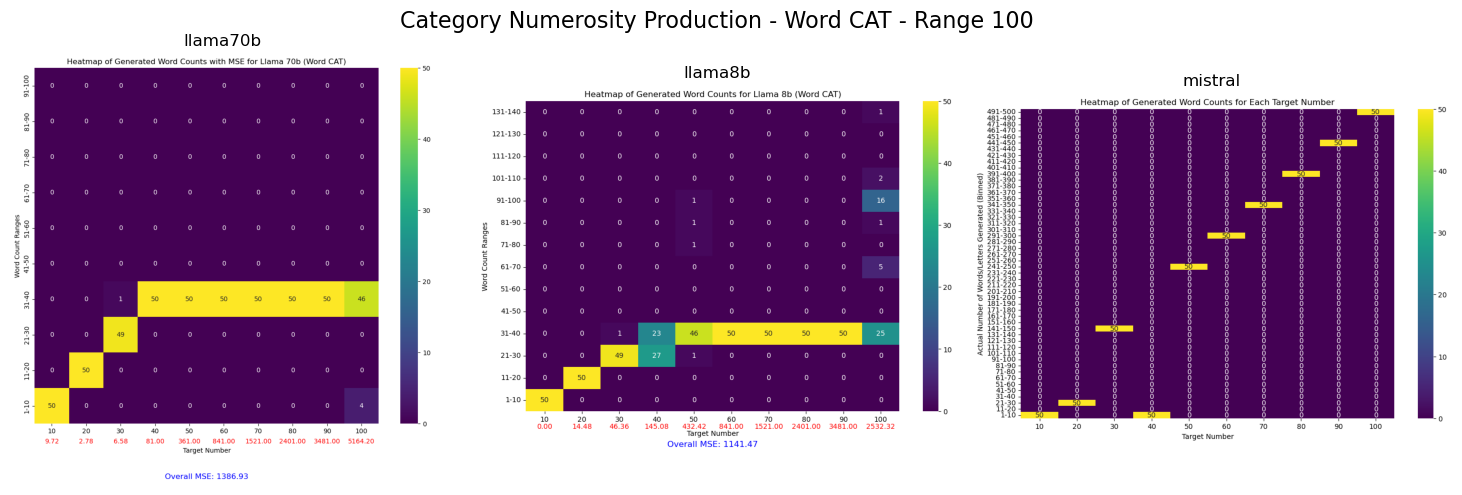

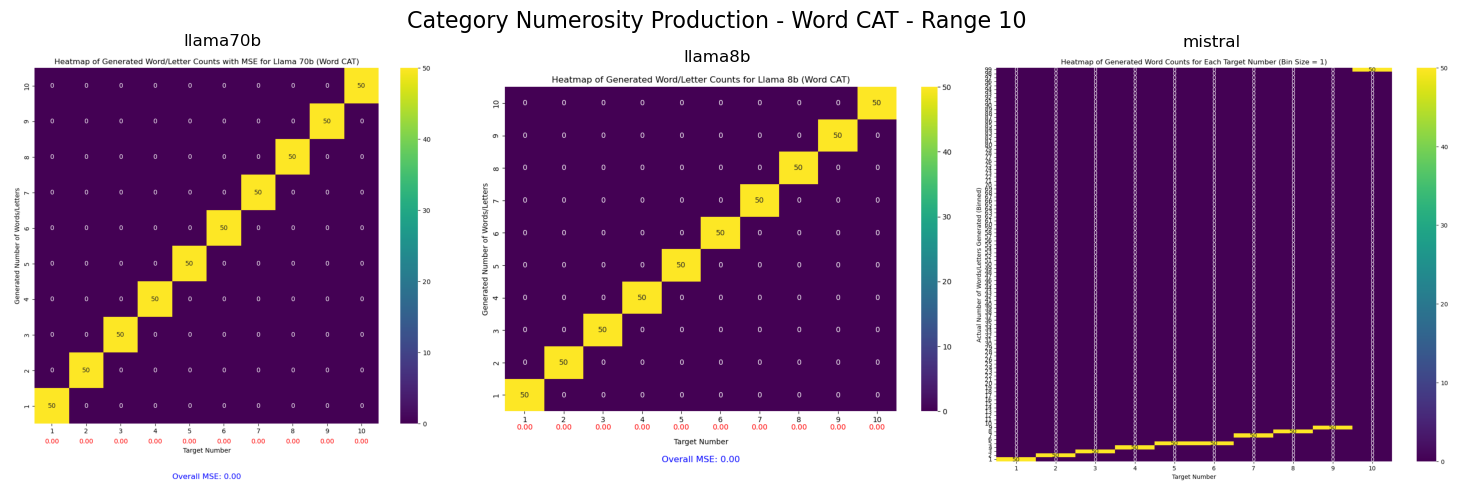

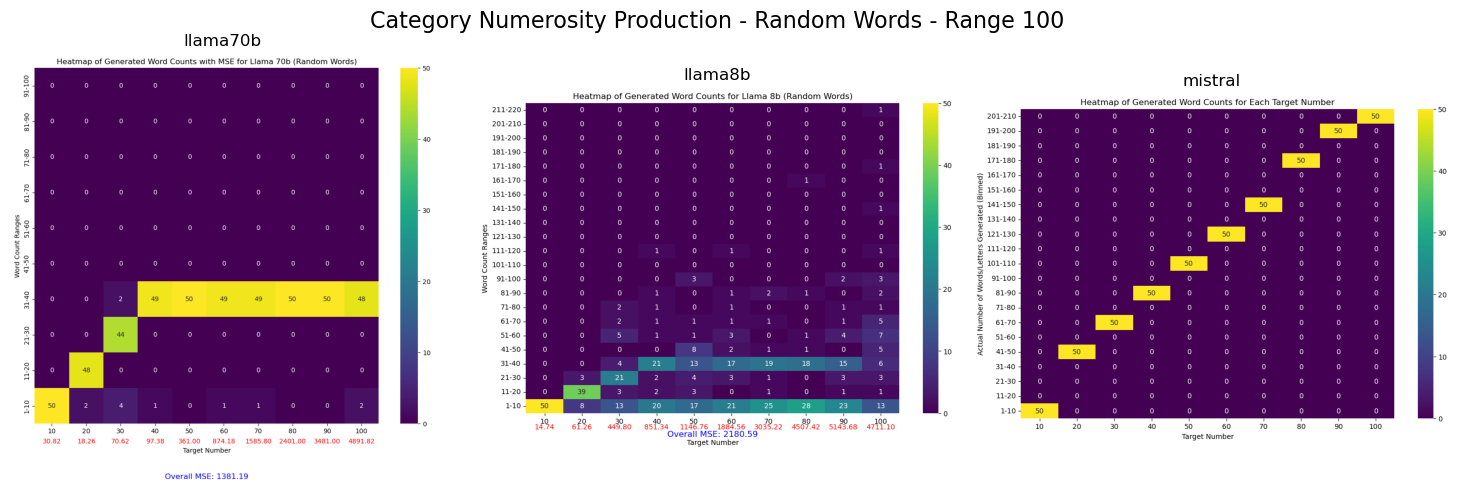

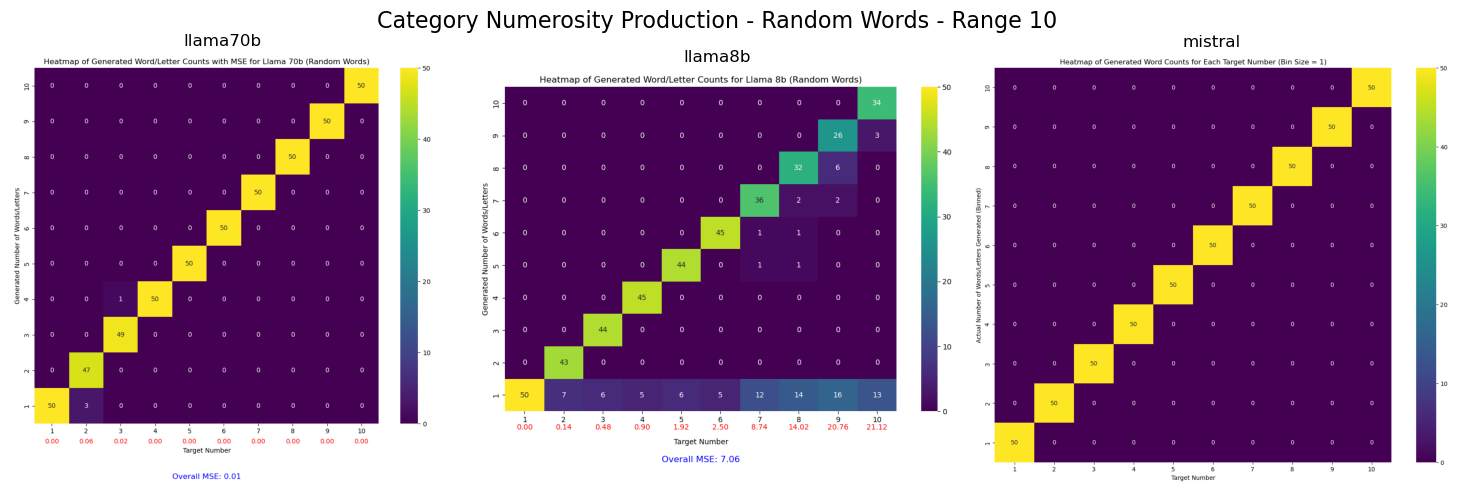

In [62]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt

# Path to the directory containing the PNG files
directory_path = r'C:\Users\Kaan\Pictures\thesis\generated'

# Dictionary to store images grouped by category and number
# Structure: {category: {number: {model_identifier: image_path}}}
images_dict = {}

# Regex pattern to match filenames and extract model, category, and number
pattern = re.compile(r'(\w+)_cat(\d+)_(\d+)_heatmap\.png')

# Traverse through the directory and collect file information
for filename in os.listdir(directory_path):
    if filename.endswith('.png'):
        match = pattern.match(filename)
        if match:
            model = match.group(1)  # Model name (e.g., 'llama8b')
            category = int(match.group(2))  # Category number
            number = int(match.group(3))  # Number after the category
            
            if category not in images_dict:
                images_dict[category] = {}
            if number not in images_dict[category]:
                images_dict[category][number] = {}
            
            # Store the image path under the model identifier
            images_dict[category][number][model] = os.path.join(directory_path, filename)

# Display images side by side for each category and number
for category, numbers in images_dict.items():
    for number, models in numbers.items():

        if category == 0:
            title_name = "Letter A"
        elif category == 1:
            title_name = "Random Letters"
        elif category == 2:
            title_name = "Word CAT"
        else:
            title_name = "Random Words"
        fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
        fig.suptitle(f'Category Numerosity Production - {title_name} - Range {number}', fontsize=16)
        
        # Iterate over models and show the images
        for i, (model, image_path) in enumerate(models.items()):
            image = Image.open(image_path)
            if len(models) == 1:
                axes.imshow(image)
                axes.axis('off')
                axes.set_title(model)
            else:
                axes[i].imshow(image)
                axes[i].axis('off')
                axes[i].set_title(model)
        
        plt.tight_layout()
        plt.show()


## Boxplot

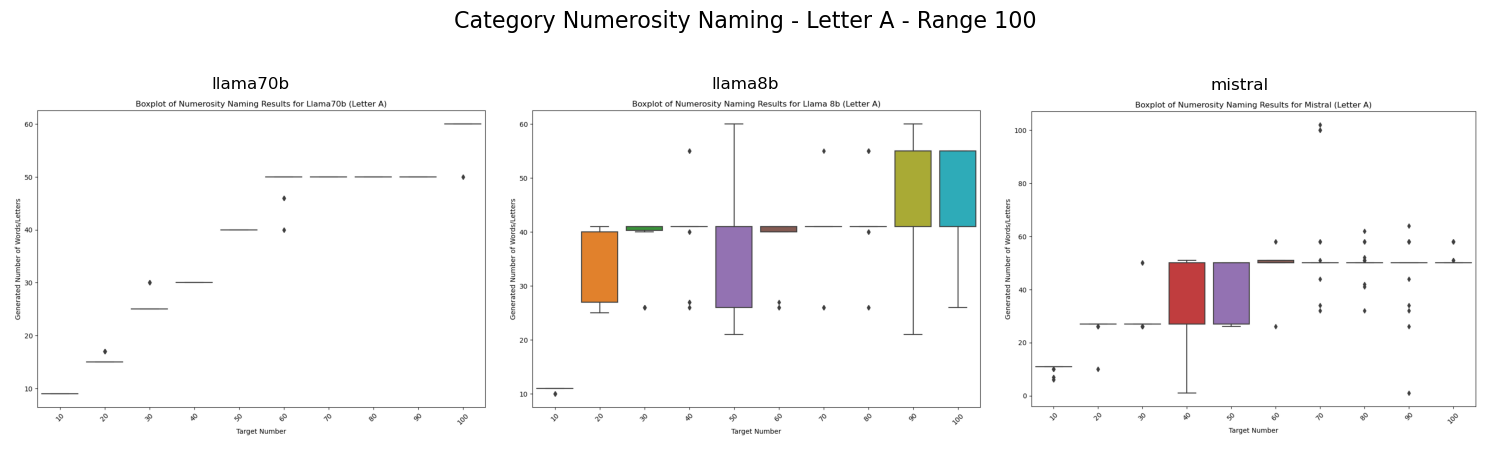

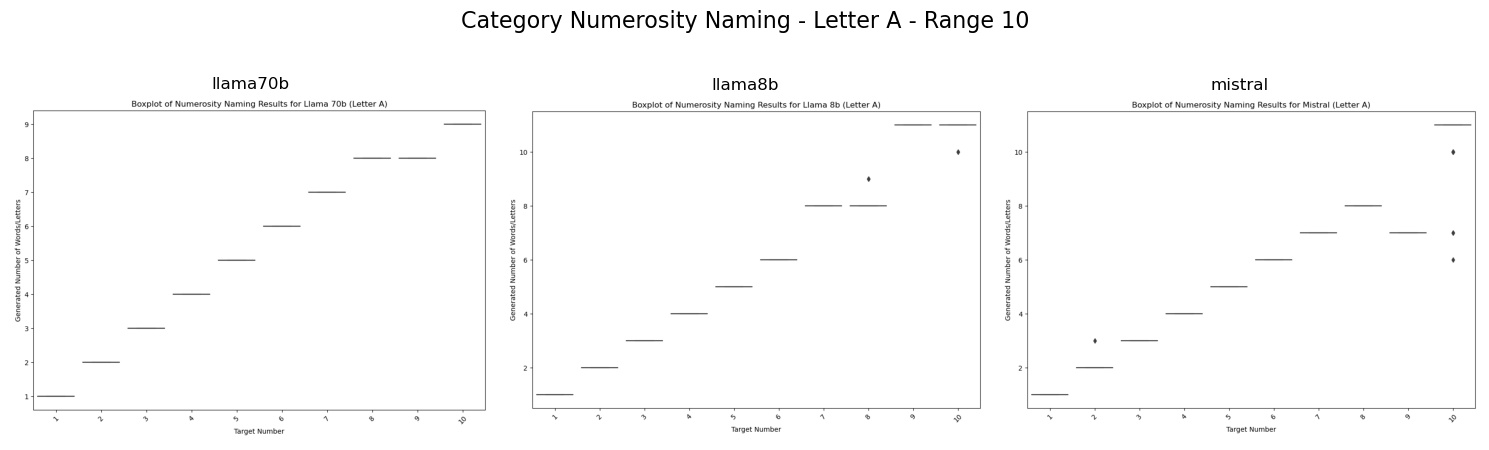

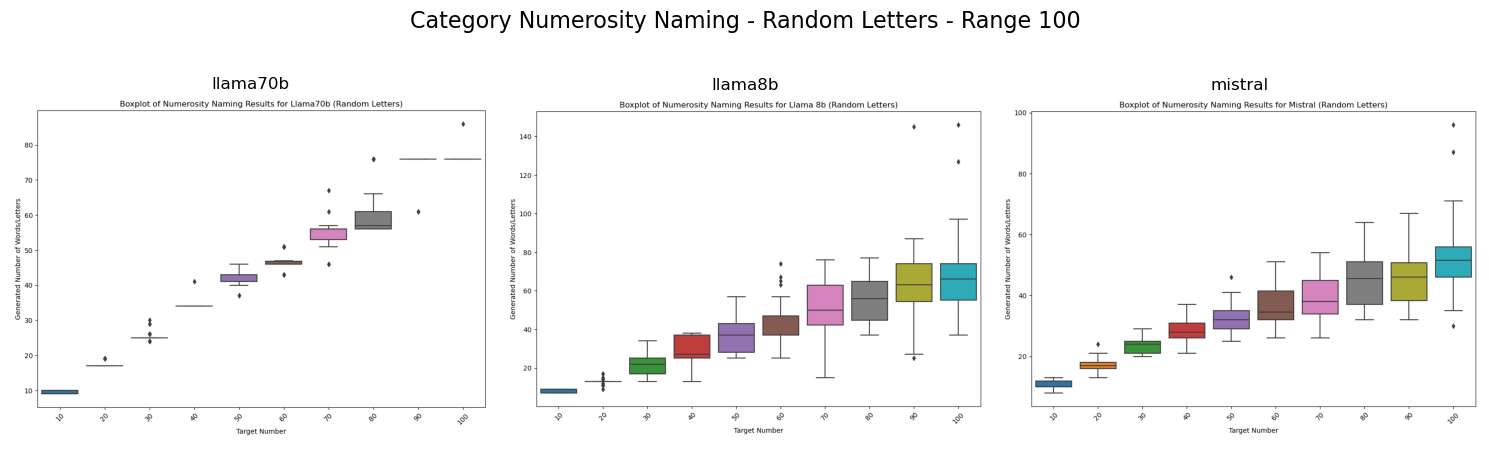

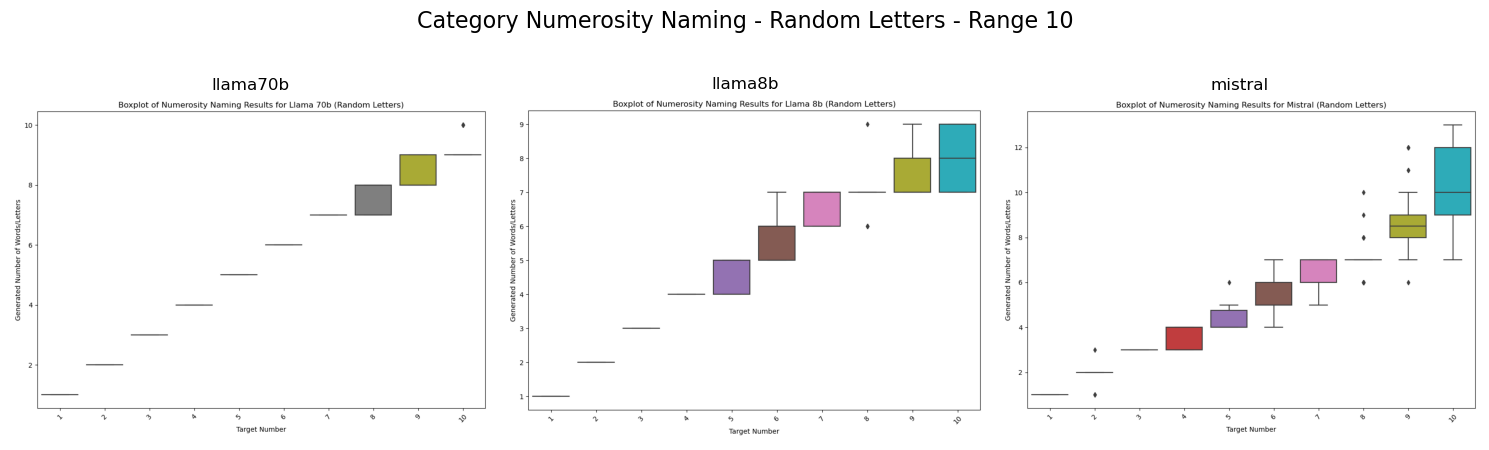

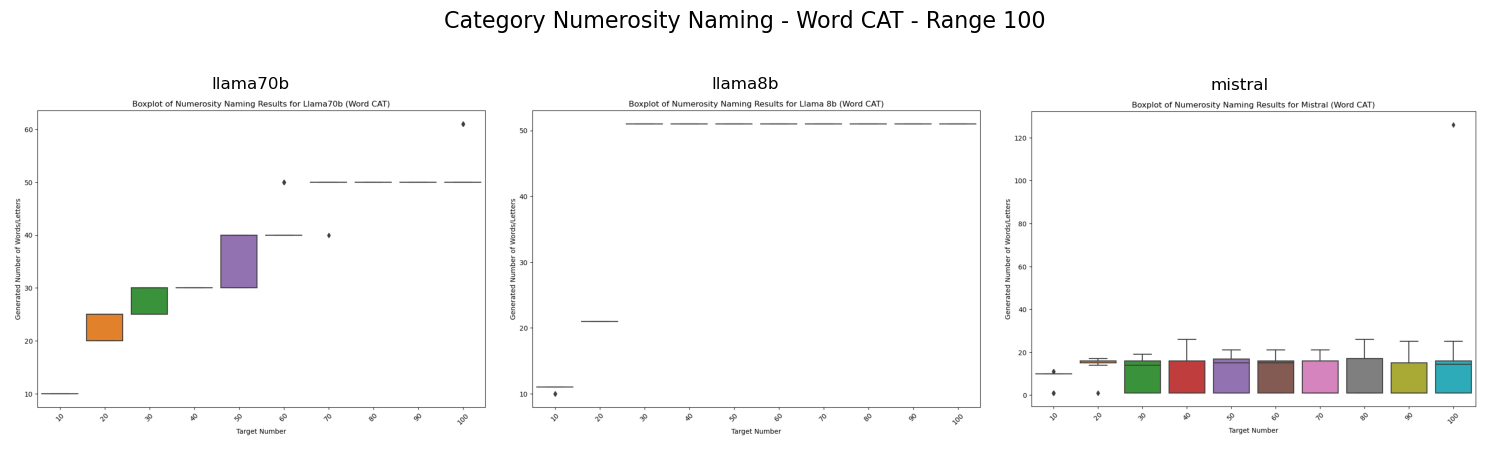

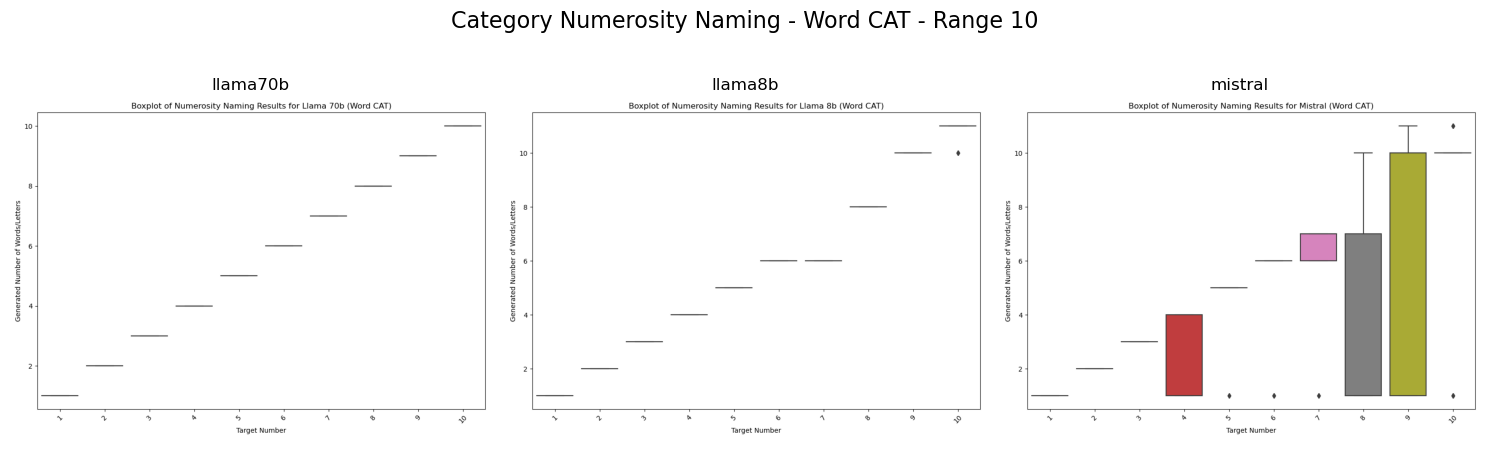

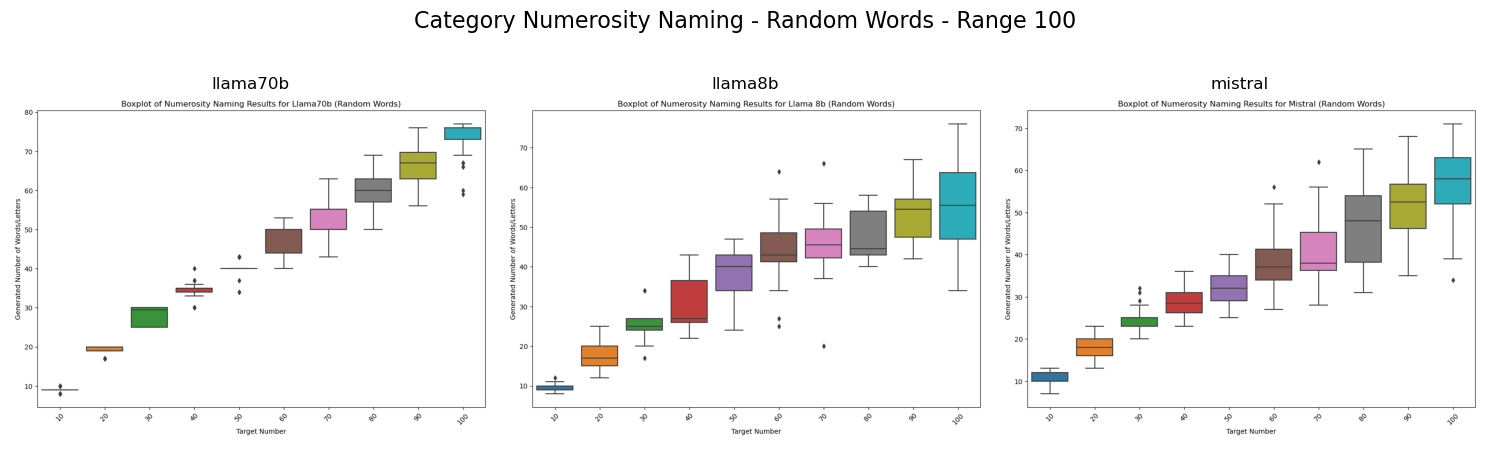

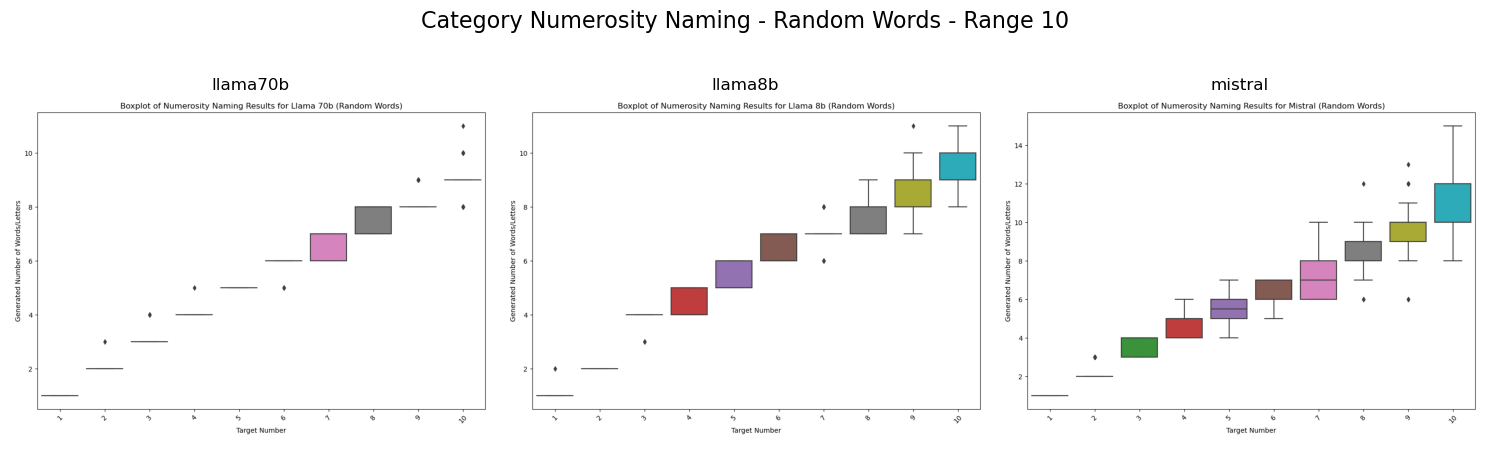

In [64]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt

# Path to the directory containing the PNG files
directory_path = r'C:\Users\Kaan\Pictures\thesis\naming'

# Dictionary to store images grouped by category and number
# Structure: {category: {number: {model_identifier: image_path}}}
images_dict = {}

# Regex pattern to match filenames and extract model, category, and number
pattern = re.compile(r'(\w+)_cat(\d+)_(\d+)_boxplot\.png')

# Traverse through the directory and collect file information
for filename in os.listdir(directory_path):
    if filename.endswith('.png'):
        match = pattern.match(filename)
        if match:
            model = match.group(1)  # Model name (e.g., 'llama8b')
            category = int(match.group(2))  # Category number
            number = int(match.group(3))  # Number after the category
            
            if category not in images_dict:
                images_dict[category] = {}
            if number not in images_dict[category]:
                images_dict[category][number] = {}
            
            # Store the image path under the model identifier
            images_dict[category][number][model] = os.path.join(directory_path, filename)

# Display images side by side for each category and number
for category, numbers in images_dict.items():
    for number, models in numbers.items():
        if category == 0:
            title_name = "Letter A"
        elif category == 1:
            title_name = "Random Letters"
        elif category == 2:
            title_name = "Word CAT"
        else:
            title_name = "Random Words"
        fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
        fig.suptitle(f'Category Numerosity Naming - {title_name} - Range {number}', fontsize=16)
        
        # Iterate over models and show the images
        for i, (model, image_path) in enumerate(models.items()):
            image = Image.open(image_path)
            if len(models) == 1:
                axes.imshow(image)
                axes.axis('off')
                axes.set_title(model)
            else:
                axes[i].imshow(image)
                axes[i].axis('off')
                axes[i].set_title(model)
        
        plt.tight_layout()
        plt.show()


# NAMING Task

In [9]:
import os
import re
from collections import defaultdict

def missing_files(directory):
    gen_data = defaultdict(list)
    missing_answers = defaultdict(list)  # To track missing or invalid answers
    
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all blocks of target number, trial, and generated num data
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: .*?\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_number = int(re.search(r'Target number: (\d+)', lines[0]).group(1))
                    
                    generated_num_match = re.search(r'Generated num: (.+)', lines[2])
                    if generated_num_match:
                        generated_num = generated_num_match.group(1).strip()
                        
                        try:
                            generated_num = int(generated_num)
                        except ValueError:
                            # Print with last 5 characters of the filename
                            print(f"Non-integer generated number found: '{generated_num}' in file '{filename[-6:]}'")
                            generated_num = None  # Set to None for invalid values
                    
                    # Check for missing, invalid or excessively large generated numbers
                    if generated_num is None or generated_num > 1e9:  # Arbitrary threshold to check large values
                        # Print with last 5 characters of the filename
                        print(f"Invalid or large generated number detected: {generated_num} in file '{filename[-6:]}'")
                        missing_answers[target_number].append(filename)  # Add the trial name to the missing list
                        generated_num = None  # No valid generated number
                    
                    # Check if answers are missing or marked as 'None'
                    answers = " ".join(lines[3:])
                    if not answers or 'None' in answers:
                        # Print with last 5 characters of the filename
                        print(f"Missing or invalid answers detected in file '{filename[-6:]}' for target {target_number}")
                        missing_answers[target_number].append(filename)  # Add the trial name to the missing list
                    
                    actual_count = len(re.findall(r'\b\w+\b', answers))
                    
                    # Only add to gen_data if the generated number is valid
                    if generated_num is not None:
                        gen_data[target_number].append({
                            'generated_num': generated_num,
                            'actual_count': actual_count
                        })
    
    # Summarize how many times each target number needs to be recreated
    recreate_summary = {}
    for target_number, trials in missing_answers.items():
        recreate_summary[target_number] = len(set(trials))  # Count unique trials
    
    print("\nSummary of target numbers needing recreation:")
    for target_number, recreate_count in recreate_summary.items():
        print(f"Target {target_number}: {recreate_count} trial(s) need to be recreated")
    
    return gen_data, recreate_summary


In [10]:
directory = r"C:\Users\Kaan\Desktop\thesis\llama3_70b\generate\llama3_70b_cat1_range100"
# Process files and get results
gen_data, recreate_summary = missing_files(directory)

print(recreate_summary)



Summary of target numbers needing recreation:
{}


### Range 10

Data successfully saved to mistral_cat3_r10_naming_data.csv


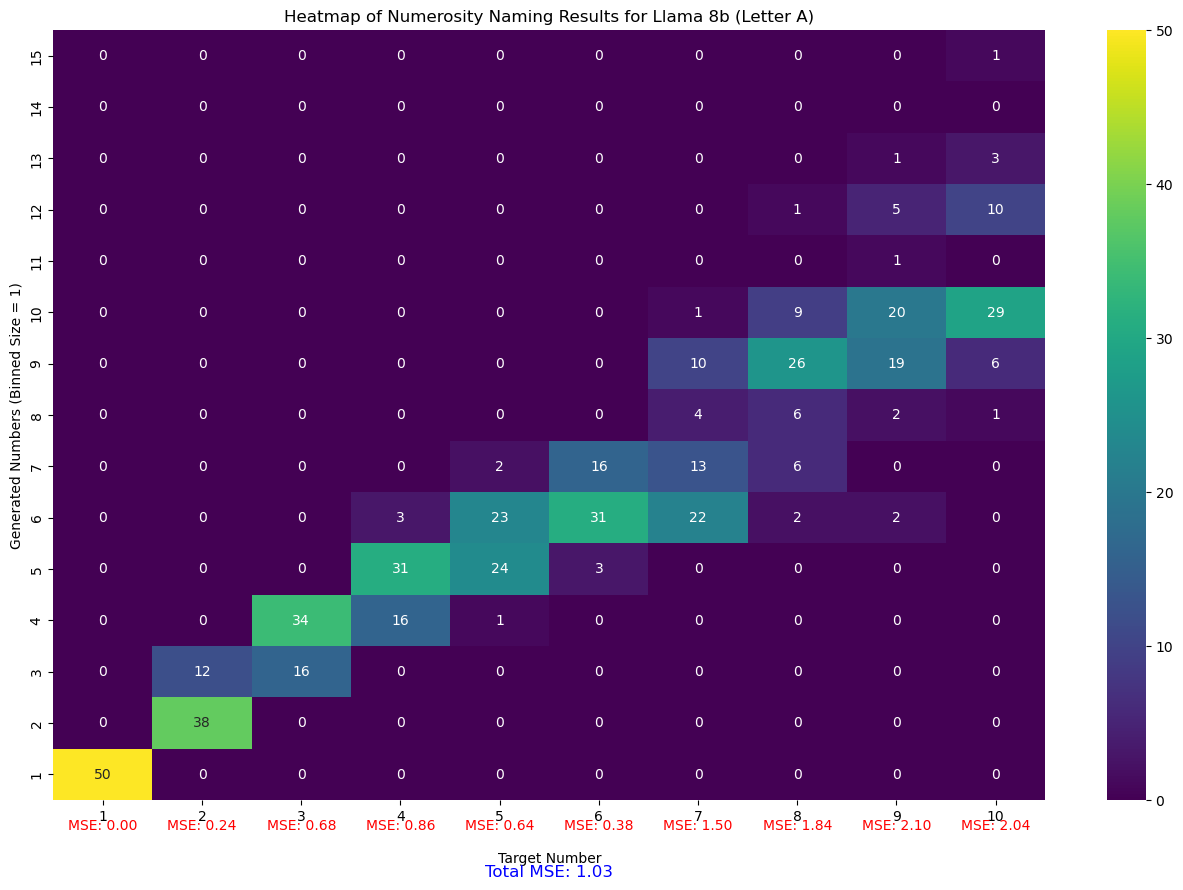

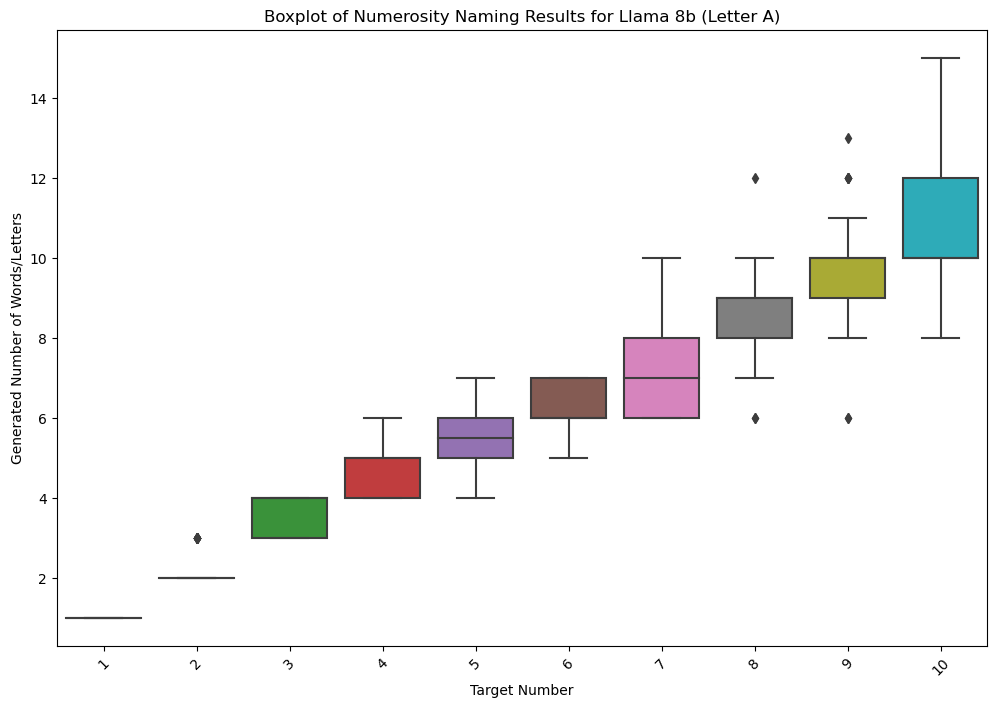

In [76]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the directory path containing your text files
directory = r"C:\Users\Kaan\Desktop\thesis\mistral\count\cat3_mistral_count_range10"

# Function to process files and extract the target number and generated counts
def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment      
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: .*?\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    
                    # Extract target number and generated num
                    target_number = int(re.search(r'Target number: (\d+)', lines[0]).group(1))
                    generated_num_match = re.search(r'Generated num: (.+)', lines[2])
                    
                    # Check if generated_num is "None" or missing and set it to 0
                    if generated_num_match:
                        generated_num = generated_num_match.group(1)
                        if generated_num == "None":
                            generated_num = 0
                        else:
                            generated_num = int(generated_num)
                    else:
                        generated_num = 0
                    
                    # Store the generated numbers and actual count for each target number
                    gen_data[target_number].append({
                        'generated_num': generated_num
                    })
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = generated_num
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "mistral_cat3_r10_naming_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")       
    return gen_data

# Calculate Mean Square Error for each target number
def calculate_mse(data):
    mse_values = {}
    for target, results in data.items():
        squared_errors = [(result['generated_num'] - target) ** 2 for result in results]
        mse = np.mean(squared_errors) if squared_errors else 0
        mse_values[target] = mse
    return mse_values

# Updated function for creating heatmap data with bins of size 1
def create_heatmap_data(data, bin_size=1):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the minimum and maximum generated number across all data to determine bin range
    all_generated_nums = [count['generated_num'] for counts in data.values() for count in counts]
    max_generated_num = max(max(all_generated_nums), 10) if all_generated_nums else 10  # Ensure it's at least 10

    # Create bins from 1 to max_generated_num + 1 to include the last number
    bins = np.arange(1, max_generated_num + 2, bin_size)
    bin_labels = [f"{i}" for i in range(1, max_generated_num + 1)]

    # Initialize heatmap data with rows equal to number of bins and columns for each target number
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the actual counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for result in data[target]:
            count = result['generated_num']
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if 0 <= bin_index < len(bins) - 1:
                heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

# Plot heatmap with MSE values
def plot_heatmap(heatmap_data, target_numbers, bin_labels, mse_values, title):
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad=20)
    plt.ylabel('Generated Numbers (Binned Size = 1)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have smaller values near the origin

    # Calculate total MSE
    total_mse = np.mean(list(mse_values.values()))

    # Annotate MSE values on top of the heatmap
    for i, target in enumerate(target_numbers):
        ax.text(i + 0.5, -0.5, f"MSE: {mse_values[target]:.2f}", color="red", ha="center", va="center")

    # Display total MSE on top of the heatmap
    plt.text(len(target_numbers) / 2, -1.5, f"Total MSE: {total_mse:.2f}", color="blue", ha="center", fontsize=12)

    plt.show()

# Convert the dictionary into a DataFrame for boxplot
def create_boxplot_data(data):
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count['generated_num']))  # Store the actual count
    
    df = pd.DataFrame(records, columns=['Target Number', 'generated_num'])
    return df

# Plot boxplot
def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='generated_num', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSE values for each target number
mse_values = calculate_mse(gen_data)

# Create heatmap data with bins of size 1
heatmap_data, bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=1)

# Plot heatmap of the generated counts with MSE annotations
plot_heatmap(heatmap_data, target_numbers, bin_labels, mse_values, 'Heatmap of Numerosity Naming Results for Llama 8b (Letter A)')

# Create boxplot data for generated counts
boxplot_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated counts 
plot_boxplot(boxplot_df, 'Generated Number of Words/Letters', 'Boxplot of Numerosity Naming Results for Llama 8b (Letter A)')


### Range 100

Data successfully saved to llama70b_cat3_r100_naming_data.csv


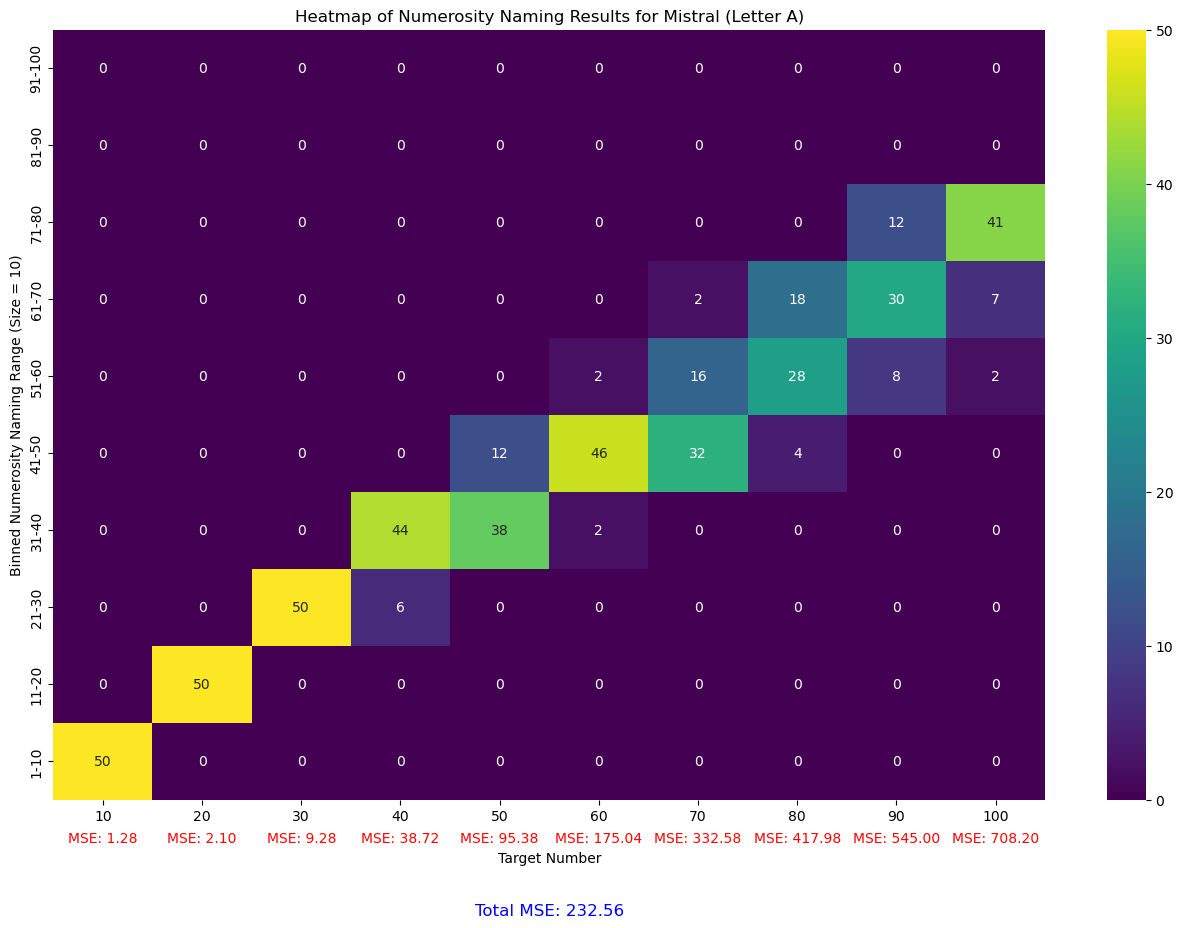

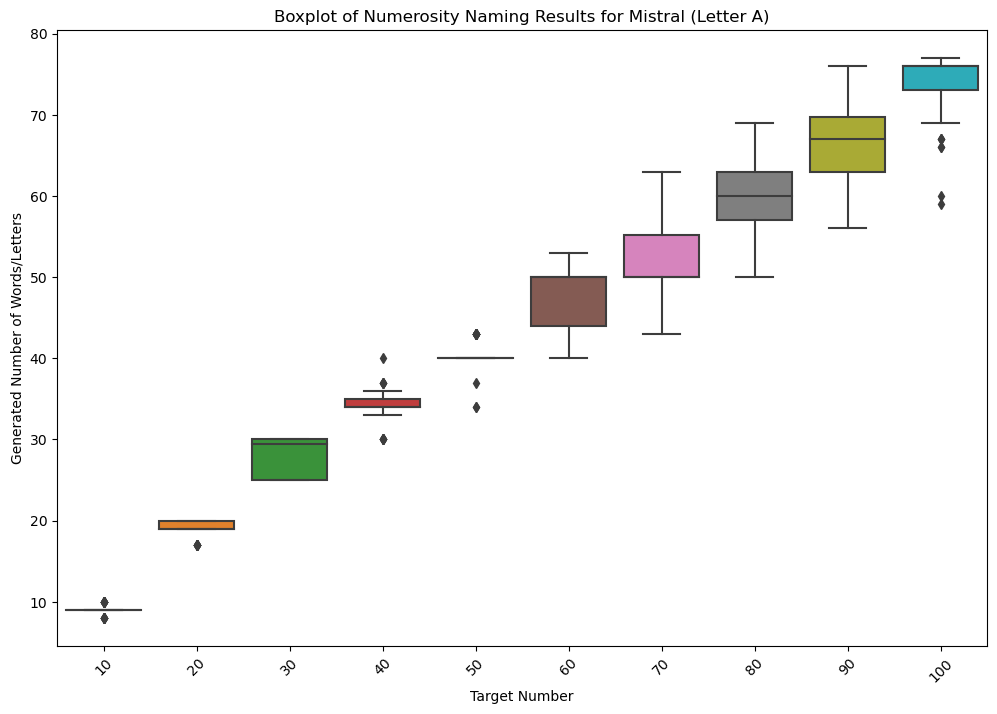

In [88]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set the directory path containing your text files
directory = r"C:\Users\Kaan\Desktop\thesis\llama3_70b\count\llama3_70b_cat3_range100"

# Function to process files and extract the target number and generated counts
def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment      
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num: .*?\s+.*?(?=Target number: \d+|$)', content, re.S)
                
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    
                    # Extract target number and generated num
                    target_number = int(re.search(r'Target number: (\d+)', lines[0]).group(1))
                    generated_num_match = re.search(r'Generated num: (.+)', lines[2])
                    
                    # Check if generated_num is "None" or missing and set it to 0
                    if generated_num_match:
                        generated_num = generated_num_match.group(1)
                        if generated_num == "None":
                            generated_num = 0
                        else:
                            generated_num = int(generated_num)
                    else:
                        generated_num = 0
                    
                    # Store the generated numbers and actual count for each target number
                    gen_data[target_number].append({
                        'generated_num': generated_num
                    })
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = generated_num
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "llama70b_cat3_r100_naming_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")    
    return gen_data

# Calculate Mean Square Error for each target number
def calculate_mse(data):
    mse_values = {}
    for target, results in data.items():
        squared_errors = [(result['generated_num'] - target) ** 2 for result in results]
        mse = np.mean(squared_errors) if squared_errors else 0
        mse_values[target] = mse
    return mse_values


# Create heatmap data with bins of size 10
def create_heatmap_data(data, bin_size=10):
    target_numbers = sorted(data.keys())  # These will be on the X-axis
    
    # Get the minimum and maximum generated number across all data to determine bin range
    all_generated_nums = [count['generated_num'] for counts in data.values() for count in counts]
    max_generated_num = max_generated_num = max(max(all_generated_nums), 100) if all_generated_nums else 100  # Ensure it's at least 100

    # Create bins starting from 1 to max generated number with a bin size of 10
    bins = np.arange(1, max_generated_num + bin_size, bin_size)
    bin_labels = [f"{bins[i]}-{bins[i + 1] - 1}" for i in range(len(bins) - 1)]
    
    # Initialize heatmap data
    heatmap_data = np.zeros((len(bins) - 1, len(target_numbers)), dtype=int)

    # Bin the actual counts into the bins and fill the heatmap data
    for i, target in enumerate(target_numbers):
        for result in data[target]:
            count = result['generated_num']
            # Find the appropriate bin index for the count
            bin_index = np.digitize(count, bins) - 1
            if 0 <= bin_index < len(bins) - 1:
                heatmap_data[bin_index][i] += 1
    
    return heatmap_data, bin_labels, target_numbers  # Return bin_labels (Y-axis) and target_numbers (X-axis)

# Plot heatmap with MSE values
def plot_heatmap(heatmap_data, target_numbers, bin_labels, mse_values, title):
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(heatmap_data, annot=True, fmt="d", xticklabels=target_numbers, yticklabels=bin_labels, cmap="viridis")
    plt.xlabel('Target Number', labelpad=20)
    plt.ylabel('Binned Numerosity Naming Range (Size = 10)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert the y-axis to have smaller values near the origin

    # Calculate total MSE
    total_mse = np.mean(list(mse_values.values()))

    # Annotate MSE values on top of the heatmap
    for i, target in enumerate(target_numbers):
        ax.text(i + 0.5, -0.5, f"MSE: {mse_values[target]:.2f}", color="red", ha="center", va="center")
    
    # Display total MSE on top of the heatmap
    plt.text(len(target_numbers) / 2, -1.5, f"Total MSE: {total_mse:.2f}", color="blue", ha="center", fontsize=12)
    
    plt.show()

# Convert the dictionary into a DataFrame for boxplot
def create_boxplot_data(data):
    records = []
    for target, counts in data.items():
        for count in counts:
            records.append((target, count['generated_num']))  # Store the actual count
    
    df = pd.DataFrame(records, columns=['Target Number', 'generated_num'])
    return df

# Plot boxplot
def plot_boxplot(df, y_label, title):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Target Number', y='generated_num', data=df)
    plt.xlabel('Target Number')
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Process files and get results
gen_data = process_files(directory)

# Calculate MSE values for each target number
mse_values = calculate_mse(gen_data)

# Create heatmap data with bins of size 10
heatmap_data, bin_labels, target_numbers = create_heatmap_data(gen_data, bin_size=10)

# Plot heatmap of the generated counts with MSE annotations
plot_heatmap(heatmap_data, target_numbers, bin_labels, mse_values, 'Heatmap of Numerosity Naming Results for Mistral (Letter A)')

# Create boxplot data for generated counts
boxplot_df = create_boxplot_data(gen_data)

# Plot the boxplot for generated counts 
plot_boxplot(boxplot_df, 'Generated Number of Words/Letters', 'Boxplot of Numerosity Naming Results for Mistral (Letter A)')


# Collect the answers in an excel sheet

In [38]:
import os
import re
import pandas as pd
from collections import defaultdict

def process_files_in_folders(base_directory, output_file):
    # Dictionary to store aggregated data in the same format as the original function
    gen_data = defaultdict(list)

    # List to temporarily store data for CSV creation
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment

    # Walk through all folders and files in the base directory
    for folder, _, files in os.walk(base_directory):
        for filename in files:
            if filename.endswith(".txt"):
                file_path = os.path.join(folder, filename)
                
                # Process each file
                with open(file_path, 'r') as file:
                    content = file.read()

                    # Extract all Target number blocks
                    target_blocks = re.findall(
                        r'Target number: (\d+)\s+Trial: (\d+)\s+Generated num: (\d+)\s+(.+?)(?=\nTarget number: \d+|$)', 
                        content, 
                        re.S
                    )

                    for block in target_blocks:
                        try:
                            # Unpack the block
                            target_number, trial, generated_num, generated_text = block
                            target_number = int(target_number)
                            generated_num = int(generated_num)
                            
                            # Store data in the original dictionary format
                            gen_data[target_number].append(generated_num)
                            
                            # Organize data for CSV creation
                            trial_index = trial_counter[target_number]
                            csv_data[trial_index][target_number] = generated_num
                            trial_counter[target_number] += 1
                        except Exception as e:
                            print(f"Error processing block: {block}, Error: {e}")

    
    # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")
    
    # Return the gen_data dictionary in the original format
    return gen_data



In [39]:
# Example Usage
directory = r"C:\Users\Kaan\Desktop\thesis\llama3_70b\count\llama3_70b_cat1_range100"  # Update with the path to your base directory
output_file = "llama70b_cat1_r100_naming_data.csv"         # Specify the output CSV file name
result = process_files_in_folders(directory, output_file)

# Output the dictionary (optional)
for target, counts in result.items():
    print(f"Target {target}: {counts}")


Data successfully saved to llama70b_cat1_r100_naming_data.csv
Target 10: [9, 9, 10, 9, 9, 9, 9, 10, 9, 10, 9, 9, 10, 9, 10, 10, 9, 10, 9, 9, 9, 9, 9, 10, 10, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 9, 10, 10, 9, 9, 9, 9, 10, 9, 10, 9, 9, 10]
Target 20: [17, 17, 17, 17, 19, 17, 19, 17, 17, 17, 19, 17, 17, 19, 17, 19, 19, 17, 17, 17, 17, 17, 17, 17, 19, 17, 17, 17, 19, 17, 17, 19, 17, 17, 17, 19, 17, 17, 19, 17, 17, 17, 19, 17, 17, 17, 17, 17, 17, 17]
Target 30: [25, 25, 25, 25, 25, 29, 25, 25, 25, 25, 29, 25, 26, 24, 24, 26, 25, 25, 26, 24, 25, 25, 25, 25, 25, 24, 26, 26, 25, 25, 26, 30, 25, 24, 29, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 24, 26, 25, 25, 26]
Target 40: [34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 41, 34, 34, 34, 34, 34, 34]
Target 50: [44, 43, 41, 43, 43, 43, 43, 43, 46, 40, 43, 41, 43, 43, 43, 41, 41, 40, 43, 43, 43, 43, 41, 43, 37, 43, 43, 41, 

In [142]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cat = None  # Define or update this variable if needed
directory = r"C:\Users\Kaan\Desktop\thesis\gemini\naming\cat3_gemini_naming_range10"

def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)', content, re.S)
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    answers = lines[3]
                    
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    generated_num = int(re.search(r'Generated num:(\d+)', generated_num_line).group(1))
                
                    letter_count = sum(c.isalpha() for c in answers)
                    cat_count = answers.count("CAT")
                    # Store the generated numbers for each target number
                    gen_data[target_number].append(cat_count)
    
                    trial_index = trial_counter[target_number]
                    csv_data[trial_index][target_number] = generated_num
                    trial_counter[target_number] += 1
    
        # Convert the CSV data to a DataFrame
    max_trials = max(trial_counter.values(), default=0)
    target_numbers = sorted(csv_data[0].keys()) if csv_data else []
    
    # Create DataFrame with rows as trials and columns as target numbers
    rows = []
    for trial_index in range(max_trials):
        row = {target: csv_data[trial_index].get(target, None) for target in target_numbers}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=target_numbers)
    df.index.name = "Trial/Target Number"  # Label rows as trials
    output_file = "gemini_cat3_r10_naming_data.csv"         # Specify the output CSV file name
    # Save the DataFrame to a CSV file
    df.to_csv(output_file, index=True)
    print(f"Data successfully saved to {output_file}")

    return gen_data


gen_data = process_files(directory)



Data successfully saved to gemini_cat3_r10_naming_data.csv


In [144]:
import os
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cat = None  # Define or update this variable if needed
directory = r"C:\Users\Kaan\Desktop\thesis\gemini\naming\cat3_gemini_naming_range10"
file_name = "gemini_cat3_r10_naming_data.csv"
def process_files(directory):
    gen_data = defaultdict(list)
    csv_data = defaultdict(dict)
    trial_counter = defaultdict(int)  # Keep track of trials per target number for row alignment
    
    # Change to the specified directory
    os.chdir(directory)
    
    # Iterate through all files in the directory
    for filename in os.listdir():
        if filename.endswith(".txt"):
            with open(filename, 'r') as file:
                content = file.read()
                
                # Find all Target number blocks
                target_blocks = re.findall(
                    r'Target number: \d+\s+Trial: \d+\s+Generated num:\d+\s+.*?(?=Target number: \d+|$)',
                    content,
                    re.S
                )
                for block in target_blocks:
                    lines = block.strip().split("\n")
                    target_line = lines[0]
                    trial_line = lines[1]
                    generated_num_line = lines[2]
                    answers = lines[3:]
                    
                    # Extract values
                    target_number = int(re.search(r'Target number: (\d+)', target_line).group(1))
                    trial_number = int(re.search(r'Trial: (\d+)', trial_line).group(1))
                    generated_number = int(re.search(r'Generated num: (\d+)', generated_num_line).group(1))
                    
                    trimmed_answers = []
                    for line in answers:
                        stripped_line = line.strip().lower()
                        if stripped_line.startswith("please") or stripped_line.startswith("this"):
                            break
                        trimmed_answers.append(line)
                    
                    all_answers_text = " ".join(trimmed_answers)
                    # Count CAT occurrences
                    cat_count = all_answers_text.count("CAT")
                    letter_count = sum(c.isalpha() for c in all_answers_text)
                    word_count = len(all_answers_text.split())
                    # Store data by trial index
                    trial_index = trial_counter[target_number]
                    
                    # Ensure the current row in csv_data has the trial number stored
                    # If the row is empty or doesn't have a Trial key, set it
                    # Note: Since different targets might have different trial counts,
                    # we store Trial number each time. The last one written for a given trial_index
                    # will be consistent if the same trial_number is used across all target numbers for that trial.
                    if 'Trial' not in csv_data[trial_index]:
                        csv_data[trial_index]['Trial'] = trial_number
                        
                    # Store CAT count under the corresponding target number
                    csv_data[trial_index][target_number] = generated_number
                    
                    trial_counter[target_number] += 1
    
    # Determine the maximum number of trials
    max_trials = max(trial_counter.values(), default=0)
    
    # Extract all columns from the first row keys
    # They should include 'Trial' and target numbers
    if csv_data:
        all_columns = set()
        for k, v in csv_data.items():
            all_columns.update(v.keys())
        # Ensure that 'Trial' is included and separated from target numbers
        target_numbers = [col for col in all_columns if col != 'Trial']
        target_numbers = sorted(target_numbers)
    else:
        target_numbers = []
    
    # Create DataFrame rows
    rows = []
    for trial_index in range(max_trials):
        row_data = csv_data[trial_index].copy()
        # Ensure that there is a 'Trial' key
        # If not found, you could handle it, but it should exist given the logic above
        if 'Trial' not in row_data:
            row_data['Trial'] = np.nan  # Or handle as you see fit
        
        # Make sure all target numbers appear as columns, if some are missing for this trial, fill with None
        for target in target_numbers:
            if target not in row_data:
                row_data[target] = None
        rows.append(row_data)

    # Create the DataFrame with 'Trial' first, followed by target numbers
    df = pd.DataFrame(rows, columns=['Trial'] + target_numbers)
    
    df.index.name = "RowIndex"
    
    output_file = file_name  # Specify the output CSV file name
    df.to_csv(output_file, index=False)  # index=False so we don't have RowIndex column
    print(f"Data successfully saved to {output_file}")

    return gen_data

gen_data = process_files(directory)


Data successfully saved to gemini_cat3_r10_naming_data.csv


In [25]:
import os
import pandas as pd

# Directory containing the text files
folder_path = r"C:\Users\Kaan\Desktop\thesis\llama3_8b\count\llama_count_cat2_range10"
output_name = 'llama8b_cat2_r10_naming_data.csv'
# Initialize a dictionary to store data
data_dict = {}

# Iterate through each text file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        # Read the file
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Parse the file content dynamically
        trial_number = None
        target_number = None

        for line in lines:
            if line.startswith("Target number:"):
                target_number = int(line.split(":")[1].strip())
            elif line.startswith("Trial:"):
                trial_number = int(line.split(":")[1].strip())
            elif line.startswith("Generated num:"):
                try:
                    generated_num = int(line.split(":")[1].strip())
                except ValueError:
                    generated_num = 0 

                # Add data to the dictionary
                if trial_number not in data_dict:
                    data_dict[trial_number] = {}
                data_dict[trial_number][target_number] = generated_num

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(data_dict, orient='index')

# Sort the columns (Target numbers)
df = df.sort_index(axis=1)

# Save the DataFrame to a CSV file
output_file = os.path.join(folder_path, output_name)
df.to_csv(output_file, index_label="Trial")

print(f"Data successfully written to {output_file}")


Data successfully written to C:\Users\Kaan\Desktop\thesis\llama3_8b\count\llama_count_cat2_range10\llama8b_cat2_r10_naming_data.csv


Combined heatmap grid saved to C:\Users\Kaan\Pictures\thesis\r10_naming_heatmap.png


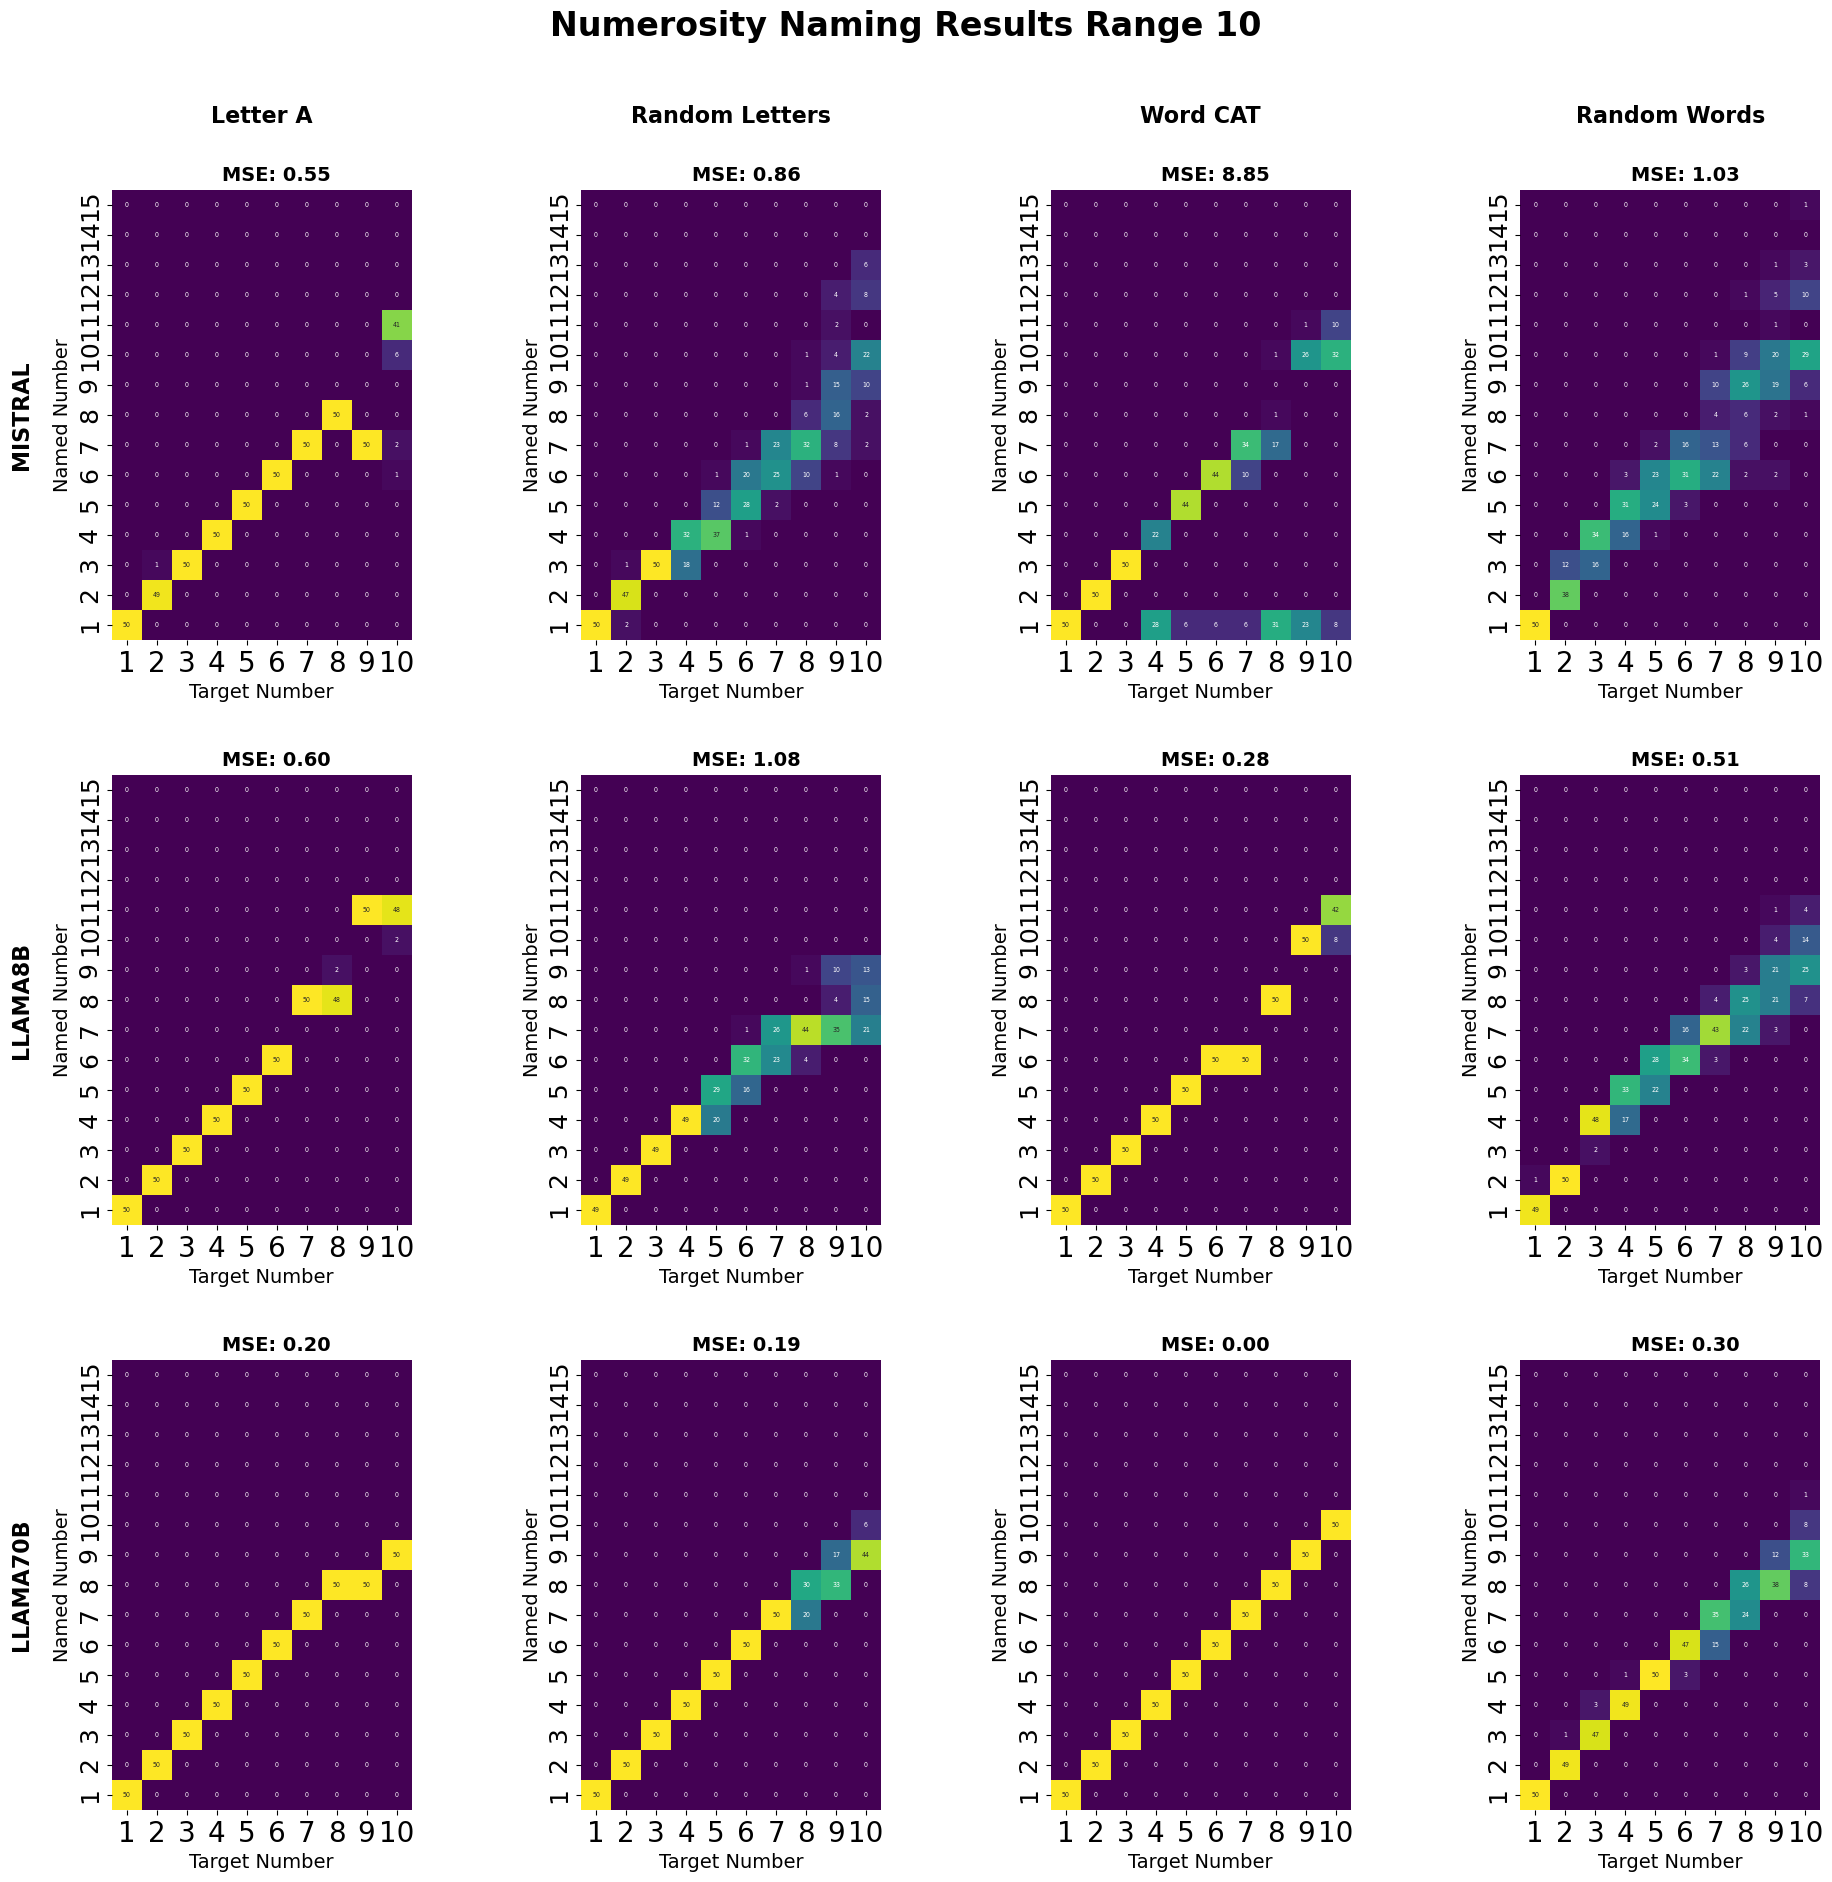

Binned heatmap grid saved to C:\Users\Kaan\Pictures\thesis\r100_naming_heatmap.png


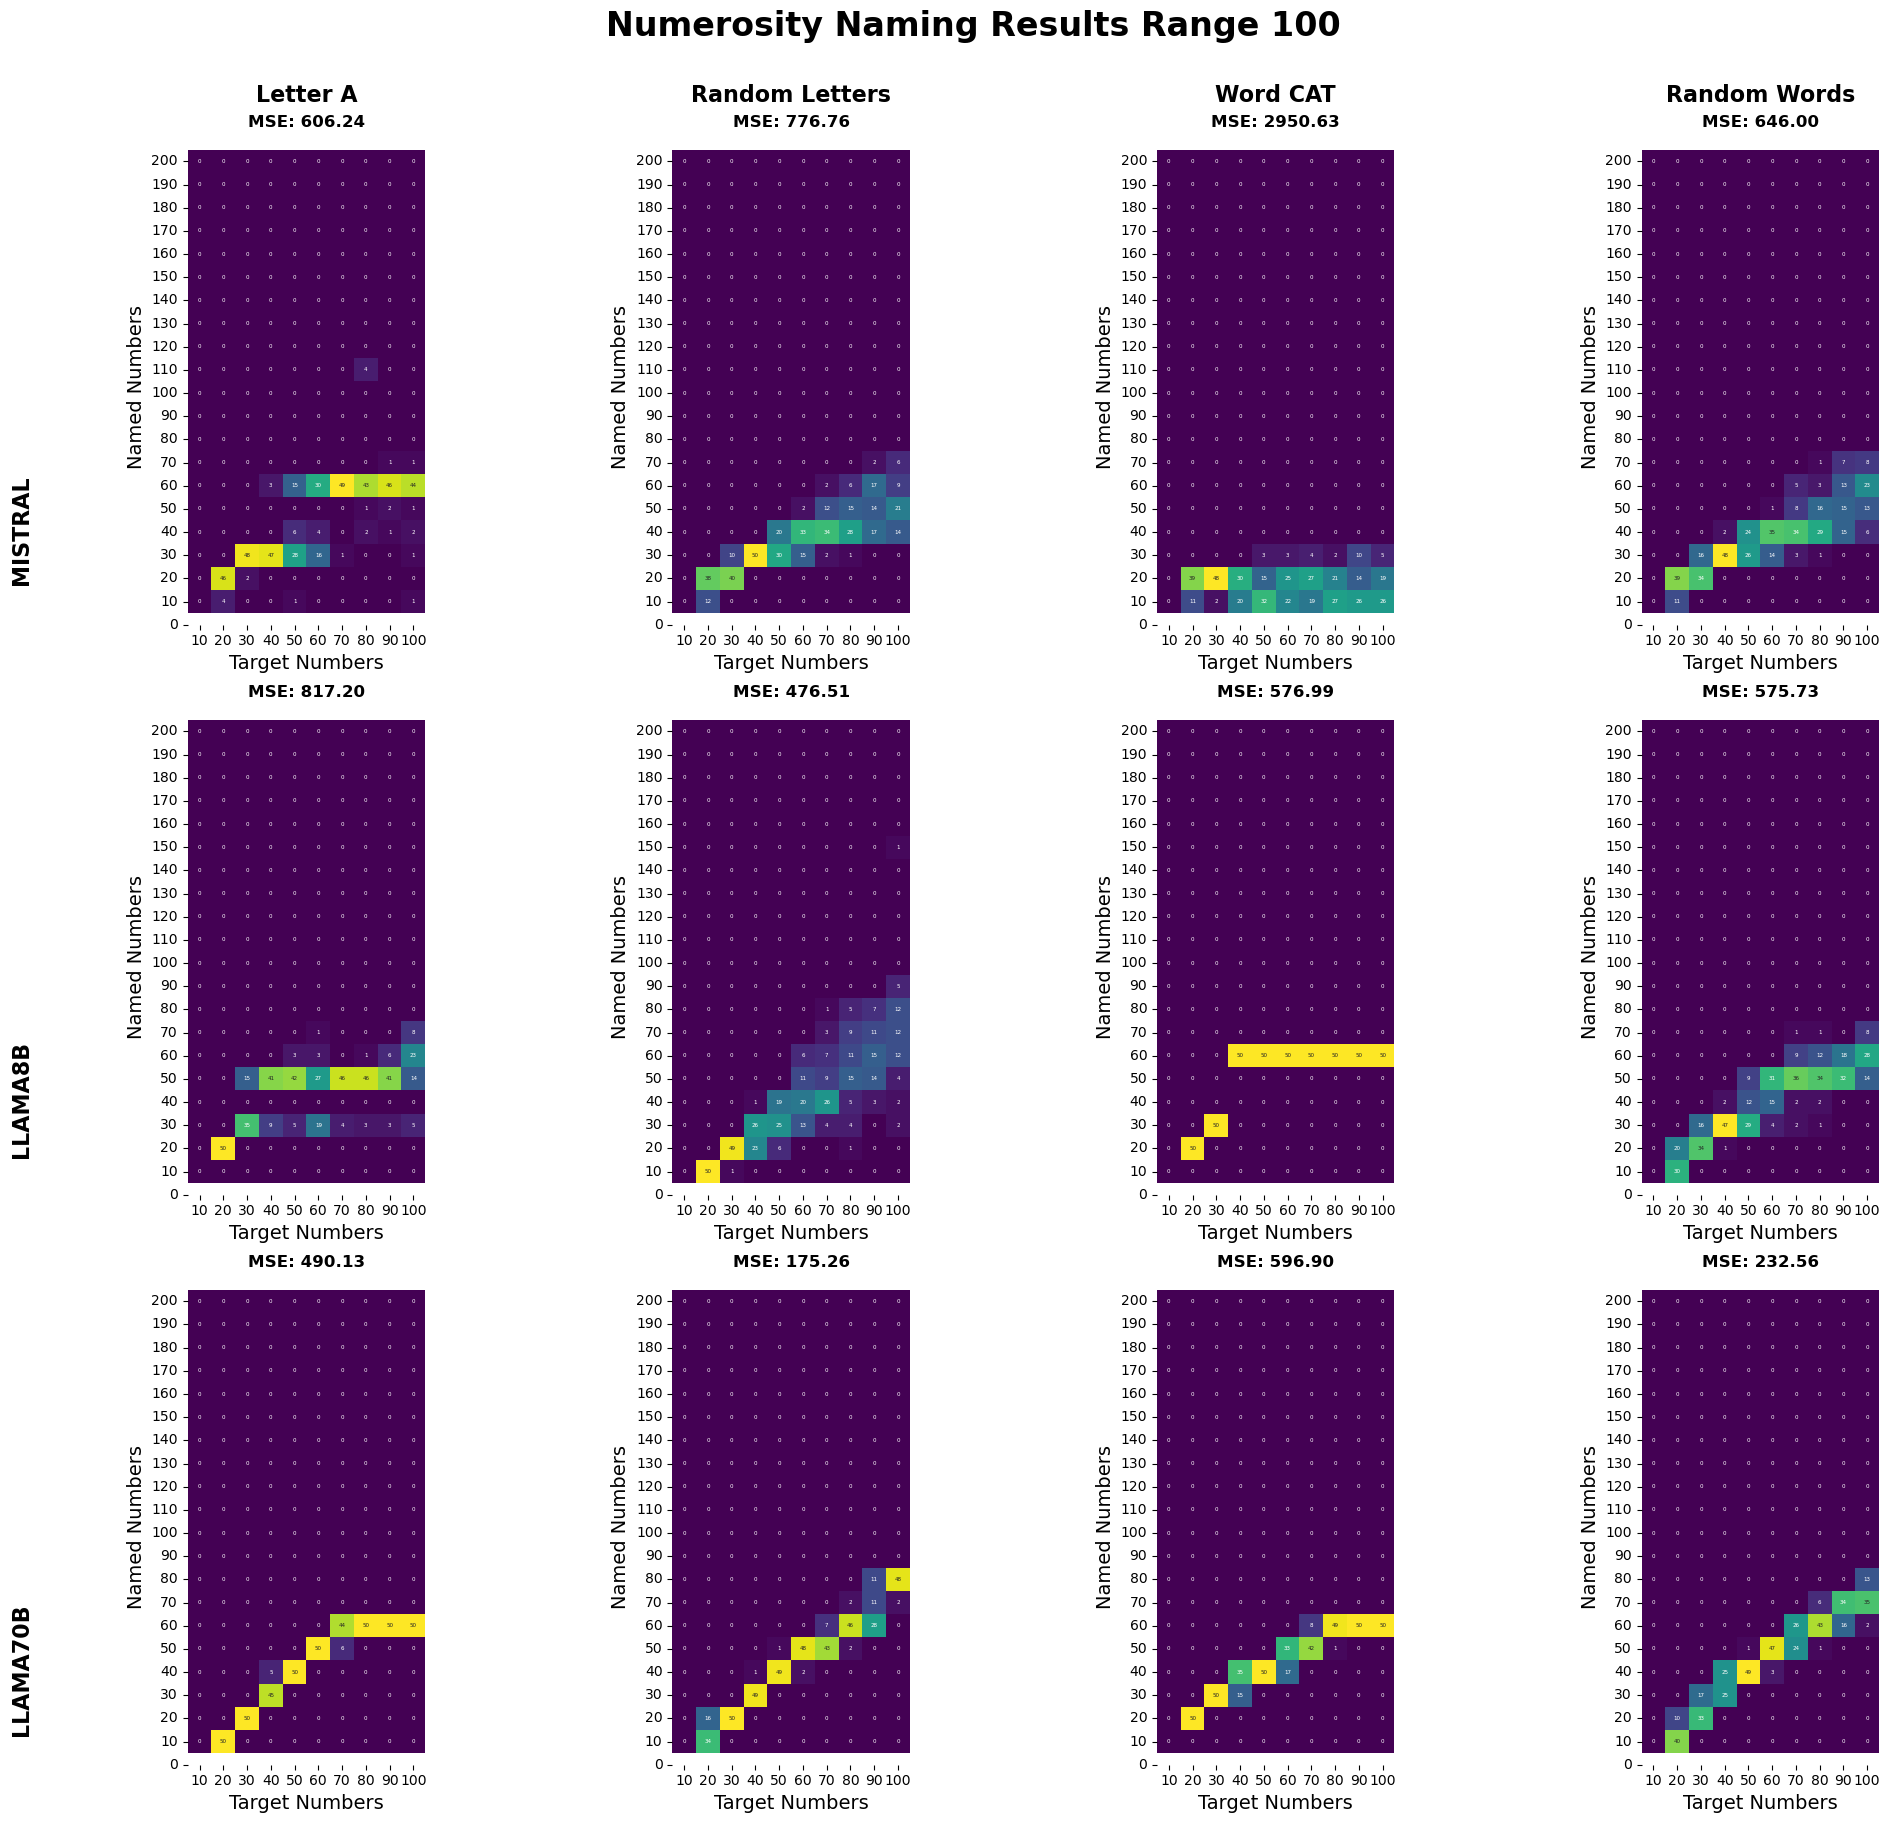

Violin plot grid saved to C:\Users\Kaan\Pictures\thesis\r10_gen_violin.png


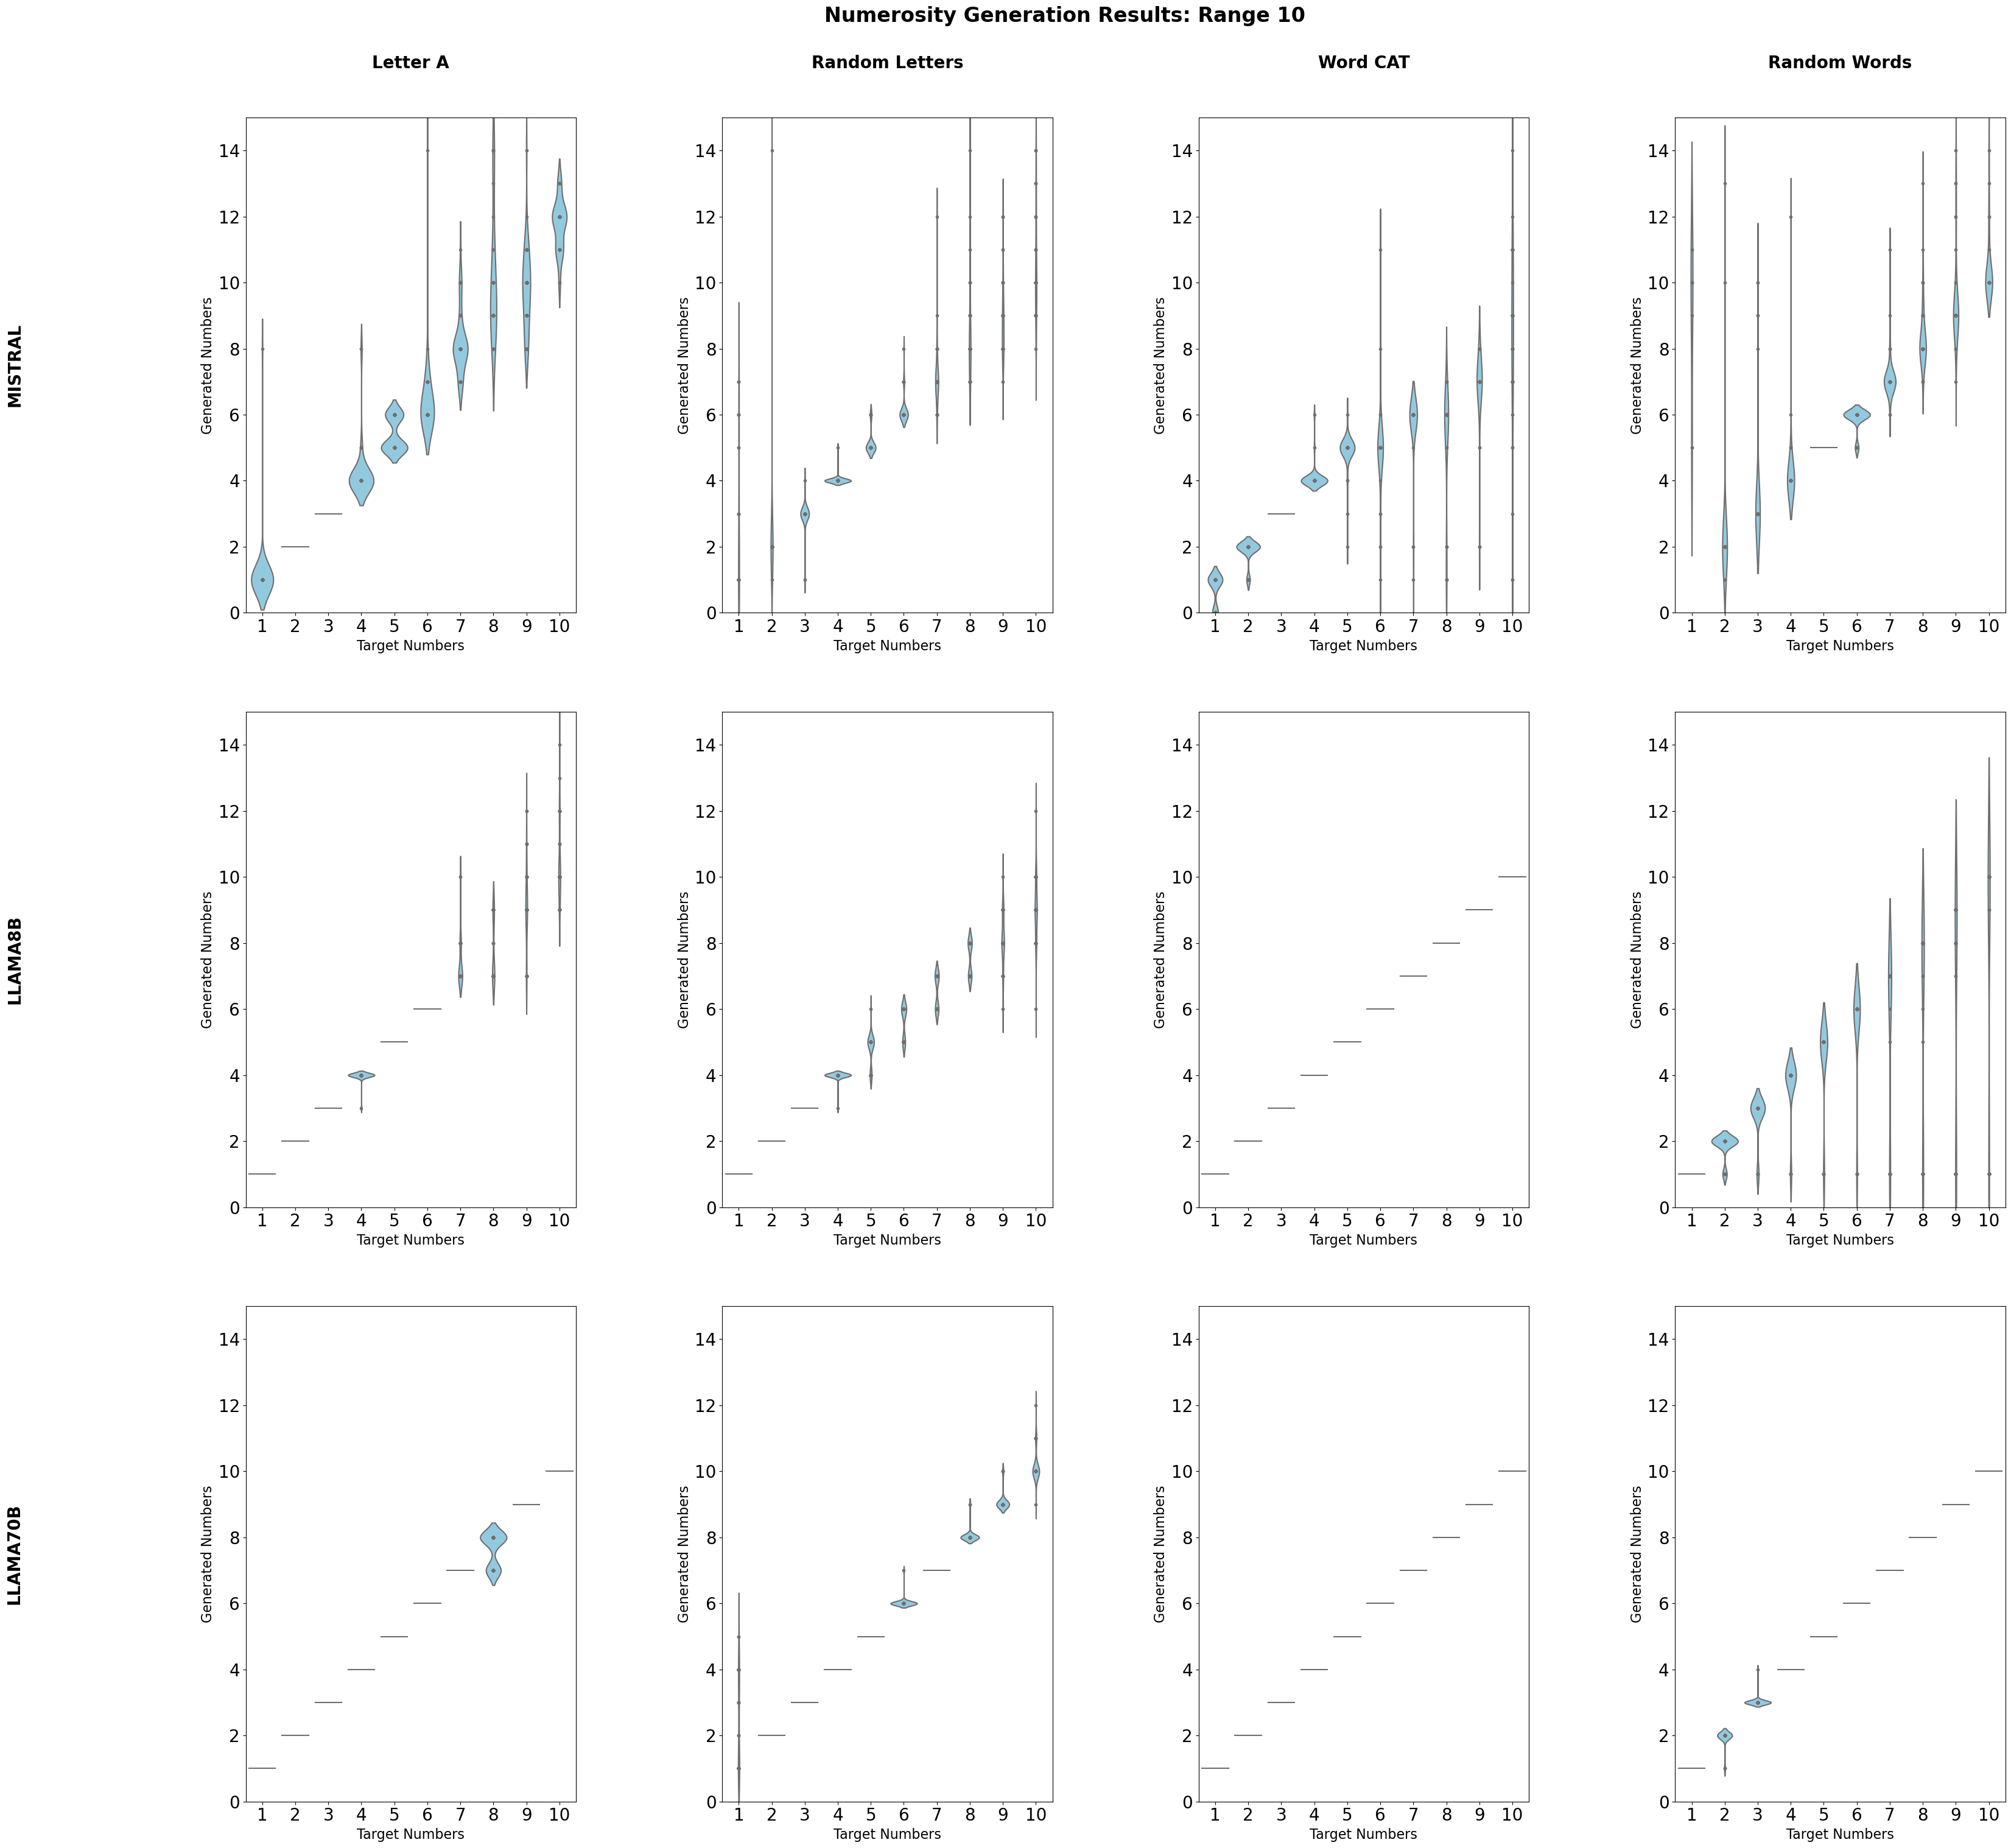